# <center>ARRA: Main Analysis</center>

# Contents

[**1. Get data**](#p1)
* [1.1 Connect to ARRA database](#p11)
* [1.2 List all relevant tables and columns](#p12)
* [1.3 Get general user data and clean it up](#p13)
* [1.4 Generate some features](#p14)
* [1.5 Basic data exploration](#p15)

[**2. Generate networks and SNA metrics**](#p2)
* [2.1 Generate a single graph](#p21)
* [2.2 Generate graphs for all users](#p22)
* [2.3 Implementing the social shift model](#p23)
* [2.4 Clean up SNA data](#p24)

[**3. Prediction**](#p3)
* [3.1 Feature subselection and preprocessing](#p31)
* [3.2 kNN](#p32)
* [3.3 Random Forest](#p33)
* [3.4 SVM](#p34)
* [3.5 PCA](#p35)

[**4. Results log**](#p4)

[**5. Version log**](#p5)

---

# <a name="p1">1. Get data<a>

## <a name="p11">1.1 Connect to ARRA database</a>

In [1]:
%matplotlib inline
import sys, os, datetime, pytz, psycopg2, time
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn; seaborn.set() # For pretty plots
from ipywidgets import FloatProgress # For the progress bar
from IPython.display import display
# %config InlineBackend.figure_format='svg' # High res plots
%config InlineBackend.figure_format='retina'

In [2]:
dbname = 'redacted'
host = 'redacted'
port = 'redacted'
user = 'redacted'
password = 'redacted'

I'll use `psycopg2`, as `sqlalchemy` can't seem to handle `LIKE` and some other simple SQL queries easily...

In [3]:
conn = psycopg2.connect(
   database = dbname,
   user = user,
   password = password,
   host = host,
   port = port
)

## <a name="p12">1.2 List all relevant tables and columns</a>

Get all the relevant table names

In [4]:
sql_query = """
            SELECT table_name 
            FROM information_schema.tables 
            WHERE table_name LIKE 'main_%'
            """
table_list = pd.read_sql(sql_query, conn)

Get all the relevant column names

In [5]:
sql_query = """
            SELECT column_name, table_name 
            FROM information_schema.columns
            WHERE table_name LIKE 'main_%'
            """
col_list = pd.read_sql(sql_query, conn)

Massage them into a nice DF

In [6]:
# Generate a dictionary containing all column names
DF_dict = {}
for name in list(table_list['table_name']):
    DF_dict[name] = list(col_list[col_list['table_name'] == name]['column_name'])

# Fill it up so all lists are equal length
max_length = max([len(f) for f in DF_dict.values()])
for key, value in DF_dict.items():
    DF_dict[key] = DF_dict[key] + ['-----'] * (max_length - len(DF_dict[key]))

# Create a DataFrame
all_columns = pd.DataFrame(DF_dict)
all_columns

,main_comment,main_failedrequests,main_instagrammedia,main_survey,main_tags,main_user,main_usersinphoto
0,id,id,id,id,id,id,id
1,created_time,access_token,type,age,tag,username,username
2,text,endpoint,mediaId,gender,photo_id,full_name,full_name
3,user_id,max_id,userId,race,-----,profilePictureUrl,profilePictureUrl
4,comment_id,-----,likes,height,-----,userId,userId
5,photo_id,-----,comments,weight,-----,profileImage,profileImage
6,-----,-----,captionText,drinks,-----,bio,photo_id
7,-----,-----,imageURL,tobacco,-----,website,-----
8,-----,-----,image,prescription_drugs,-----,media,-----
9,-----,-----,importDate,illegal_drugs,-----,follows,-----


## <a name="p13">1.3 Get general user data and clean it up</a>

Note `LEFT JOIN`, since some user may not have any media data, and also we're (temporarily) including `survey_id` column to weed out multiple entries:

In [7]:
sql_query = """
            SELECT distinct main_user."userId", age, gender, race, height, weight, drinks, 
                   tobacco, illegal_drugs, prescription_drugs, media, likes, comments, follows, followed_by,
                   breakup, creativity, death_loved, food, happy, major_friendship, narcissist, other_loss, 
                   phq1, phq2, phq3, phq4, phq5, phq6, phq7, phq8
            FROM main_user
            JOIN main_survey 
            ON main_user.survey_id = main_survey.id 
            LEFT JOIN (
                       SELECT SUM(likes) AS likes, sum(comments) AS comments, survey_id AS id 
                       FROM main_instagrammedia 
                       GROUP BY survey_id
                      ) media_totals 
            ON main_survey.id = media_totals.id;
            """
arradata = pd.read_sql(sql_query, conn)
len(arradata)

3230

In [9]:
arradata.ix[:,1:].head() # Omitting 1st column since it contains user IDs

,age,gender,race,height,weight,drinks,tobacco,illegal_drugs,prescription_drugs,media,...,narcissist,other_loss,phq1,phq2,phq3,phq4,phq5,phq6,phq7,phq8
0,31,Female,White,157,70,Monthly,Once or Twice,Once or Twice,Never,62,...,Disagree,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31,Male,White,188,86,Monthly,Once or Twice,Once or Twice,Never,0,...,Agree,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20,Female,White,163,41,Once or Twice,Never,Once or Twice,Never,417,...,Strongly disagree,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22,Female,White,183,95,Once or Twice,Once or Twice,Daily or Almost Daily,Never,456,...,Agree,True,3.0,3.0,2.0,2.0,2.0,3.0,3.0,1.0
4,39,Female,Black,155,82,Never,Never,Never,Never,48,...,Disagree,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Remove duplicate users (this is from the initial testing phase; in future there can be no multiple users, since if they fill out a survey multiple times, the `survey_id` field in the `main_user` table always points to the first survey they filled out, i.e. additional surveys are saved in our system but are never associated with a user):

In [10]:
arradata = arradata.drop_duplicates('userId')

These are the new survey fields:

In [11]:
new_survey_fields = ['breakup', 'creativity', 'death_loved', 'food', 
                     'happy', 'major_friendship', 'narcissist', 'other_loss']

In [12]:
new_survey_fields2 = ['phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8']

Count how many surveys don't have an entry there (for each question)

In [13]:
sum(arradata['breakup'].isnull())

111

In [14]:
sum(arradata['phq1'].isnull())

1202

We should either disregard these or try to impute them. If we want to disregard them, we need to know which users are these:

In [15]:
early_users = arradata['userId'][arradata['breakup'].isnull()].tolist()
len(early_users)

111

In [16]:
early_users2 = arradata['userId'][arradata['phq1'].isnull()].tolist()
len(early_users2)

1202

Alternatively, we could impute them. Since all the questions are categorical and there are expected neutral answers, a cheap way of imputing them is to just use those answers, or simply look at the most frequent answers (should be similar). (Later: something more fancy, like kNN). 

In [17]:
arradata_newfields_newusers = arradata[~arradata['userId'].isin(early_users)][new_survey_fields]
most_freq_answers = arradata_newfields_newusers.apply(lambda x:x.value_counts().idxmax())
most_freq_answers

breakup                     False
creativity          More creative
death_loved                 False
food                     Disagree
happy                       Agree
major_friendship            False
narcissist               Disagree
other_loss                  False
dtype: object

In [18]:
arradata_newfields_newusers2 = arradata[~arradata['userId'].isin(early_users2)][new_survey_fields2]
most_freq_answers2 = arradata_newfields_newusers2.apply(lambda x:x.value_counts().idxmax())
most_freq_answers2

phq1    0.0
phq2    1.0
phq3    1.0
phq4    1.0
phq5    0.0
phq6    0.0
phq7    0.0
phq8    0.0
dtype: float64

In [19]:
new_fields_fillna_dict = {most_freq_answers.index[i]: most_freq_answers[i] 
                          for i in range(len(most_freq_answers))}
arradata = arradata.fillna(new_fields_fillna_dict)

In [20]:
new_fields_fillna_dict2 = {most_freq_answers2.index[i]: most_freq_answers2[i] 
                          for i in range(len(most_freq_answers2))}
arradata = arradata.fillna(new_fields_fillna_dict2)

Convert the phq survey fields values to integers:

In [21]:
arradata['phq1'] = arradata['phq1'].astype(int)
arradata['phq2'] = arradata['phq2'].astype(int)
arradata['phq3'] = arradata['phq3'].astype(int)
arradata['phq4'] = arradata['phq4'].astype(int)
arradata['phq5'] = arradata['phq5'].astype(int)
arradata['phq6'] = arradata['phq6'].astype(int)
arradata['phq7'] = arradata['phq7'].astype(int)
arradata['phq8'] = arradata['phq8'].astype(int)

Quantify survey answers:

In [22]:
quantify_substances = {'Never': 1, 'Once or Twice': 2, 'Monthly': 3, 'Weekly': 4, 'Daily or Almost Daily': 5}

In [23]:
arradata['drinks'] = arradata['drinks'].replace(quantify_substances)
arradata['tobacco'] = arradata['tobacco'].replace(quantify_substances)
arradata['illegal_drugs'] = arradata['illegal_drugs'].replace(quantify_substances)
arradata['prescription_drugs'] = arradata['prescription_drugs'].replace(quantify_substances)
#print arradata.head()

Replace the `NaN`'s in comments and likes (due to left join) with 0's:

In [24]:
arradata = arradata.fillna({'comments': 0, 'likes': 0})

Convert likes and comments to integers:

In [25]:
arradata['likes'] = arradata['likes'].astype(int)
arradata['comments'] = arradata['comments'].astype(int)

Check there are no more missing data:

In [26]:
arradata.isnull().values.any()

False

Also remove ridiculous entries

In [27]:
arradata = arradata[arradata['age'] < 100]
arradata = arradata[arradata['age'] > 17]

Set the user id as the index, since it will be easier to merge with SNA later:

In [28]:
# Final check that there are no duplicates and we can indeed use the userid columns as an index
arradata['userId'].shape[0] - arradata['userId'].unique().shape[0]

0

In [29]:
arradata.index = list(arradata['userId'])
arradata = arradata.drop('userId', axis = 1)

Finally, this is how many healthy records we have:

In [30]:
no_raw_features = arradata.shape[1]
arradata.shape

(3196, 30)

## <a name="p14">1.4 Generate some features</a>

Generate some potentially interesting features:

In [31]:
arradata['mean_likes'] = arradata['likes'] / (arradata['media'] + 1)
arradata['mean_comments'] = arradata['comments'] / (arradata['media'] + 1)
arradata['follow_ratio'] = arradata['followed_by'] / (arradata['follows'] + 1)
arradata['magnetism'] = arradata['mean_likes'] * arradata['mean_comments'] * arradata['follow_ratio']
arradata['bmi'] = arradata['weight'] / ((arradata['height'] / 100) **2)

In [32]:
arradata['log_follow_ratio'] = np.log(arradata['follow_ratio'] + 1)
arradata['log_mean_activity'] = np.log(arradata['mean_likes'] * arradata['mean_comments'] + 1)
arradata['log_magnetism'] = np.log(arradata['magnetism'] + 1)

Assign a BMI category:

In [33]:
def bmi_cat(bmi):
    if bmi < 18.5: bmi_score = 'Underweight'
    elif bmi < 25.0: bmi_score = 'Normal'
    elif bmi < 30.0: bmi_score = 'Overweight'
    else: bmi_score = 'Obese'
    return bmi_score

In [34]:
arradata['bmi_cat'] = arradata[['bmi']].applymap(bmi_cat)['bmi']

Ben's health score

In [35]:
bmi_score = {'Underweight': 2, 'Normal': 1, 'Overweight': 3, 'Obese': 4}
bmi_score_f = lambda t: bmi_score[t]

In [36]:
arradata['health_score'] = (arradata['drinks'] + arradata['tobacco'] + arradata['prescription_drugs'] + 
                            arradata['illegal_drugs'] + arradata[['bmi_cat']].applymap(bmi_score_f)['bmi_cat'])

Attempt to quantify the amount of social shift:

In [37]:
arradata['social_shift'] = (arradata['major_friendship'].astype(int) + 
                            arradata['breakup'].astype(int) +
                            arradata['death_loved'].astype(int) + 
                            arradata['other_loss'].astype(int))

Let's extract the typical time and kind of day of posting and the length of the caption text.

In [38]:
sql_query = """
            SELECT "userId", "captionText", "createdTime" 
            FROM main_instagrammedia
            """
tt = pd.read_sql(sql_query, conn)

The caption length is easy:

In [40]:
tt['caption_length'] = tt['captionText'].str.len().fillna(0)
arradata['mean_caption_length'] = tt['caption_length'].groupby(tt['userId']).mean()
arradata['mean_caption_length'] = arradata['mean_caption_length'].fillna(0)

For time of day, define what's morning, what afternoon, etc.

In [41]:
time_of_day = {}
for i in range(0, 6): time_of_day[i] = 'Night'
for i in range(6, 12): time_of_day[i] = 'Morning'
for i in range(12, 18): time_of_day[i] = 'Afternoon'
for i in range(18, 24): time_of_day[i] = 'Evening'                

Functions to convert unix timestamp to the time of day and whether or not it is a weekday:

In [42]:
utc_tz = pytz.timezone("UTC")
cnt_tz = pytz.timezone("US/Central")
def get_timeofday(timestamp):
    utc_time = datetime.datetime.utcfromtimestamp(timestamp)
    cnt_time = utc_tz.localize(utc_time).astimezone(cnt_tz)
    hour = cnt_time.hour
    return time_of_day[hour]
def is_weekday(timestamp):
    utc_time = datetime.datetime.utcfromtimestamp(timestamp)
    cnt_time = utc_tz.localize(utc_time).astimezone(cnt_tz)
    wday = cnt_time.weekday()
    if wday <= 4: weekday = True
    else: weekday = False
    return weekday

Apply them to the time and text DF (might take a sec or two due to the slow `applymap`)

In [43]:
tt['is_weekday'] = tt[['createdTime']].applymap(is_weekday)['createdTime']
tt['time_of_day'] = tt[['createdTime']].applymap(get_timeofday)['createdTime']
tt.ix[:,1:].head()

,captionText,createdTime,caption_length,is_weekday,time_of_day
0,Dinner party attire #ootd I swear I was happie...,1474792260,68.0,False,Night
1,@carriehayes4's maid of honor? Yeah fine I gue...,1474658703,313.0,True,Afternoon
2,NYC doesn't have palm trees. LA does.,1474577209,37.0,True,Afternoon
3,"Not the best picture, but it sure does capture...",1474483281,184.0,True,Afternoon
4,hot and fresh out the kitchen 🍔🍟,1474318193,38.0,True,Afternoon


What is the typical day (i.e. weekday or weekend) when a user posts? (Note the rough imputation...)

In [44]:
week_av = tt['is_weekday'].groupby(tt['userId']).mean()

In [45]:
def weekday_decide(x):
    if x >= (5. / 7.): weekday = True
    else: weekday = False
    return weekday

In [46]:
week_av = week_av.apply(weekday_decide)
arradata['av_post_weekday'] = week_av
most_common_weekday = week_av.value_counts().idxmax()

In [47]:
# arradata['av_post_weekday'] = arradata['av_post_weekday'].fillna(most_common_weekday)
arradata['av_post_weekday'] = arradata['av_post_weekday'].fillna(2)
arradata['av_post_weekday'] = arradata['av_post_weekday'].astype(int)

For that typical kind day, what is the typical time the user posts? (Again, note the new category for NA)

In [48]:
tod = tt['time_of_day'].groupby([tt['userId'], tt['is_weekday']]).value_counts().unstack()

In [49]:
tod_freq = pd.Series()
for u in tod.index.levels[0].tolist():
    tod_freq[u] = tod.loc[u, week_av[u]].idxmax()

In [50]:
arradata['av_time_of_day'] = tod_freq
arradata['av_time_of_day'] = arradata['av_time_of_day'].fillna('N/A')

We finally have:

In [59]:
arradata.reset_index().ix[:,1:].head()

,age,gender,race,height,weight,drinks,tobacco,illegal_drugs,prescription_drugs,media,...,bmi,log_follow_ratio,log_mean_activity,log_magnetism,bmi_cat,health_score,social_shift,mean_caption_length,av_post_weekday,av_time_of_day
0,31,Female,White,157,70,3,2,2,1,62,...,28.398718,1.929910,0.180051,0.770920,Overweight,11,2,38.290323,0,Night
1,31,Male,White,188,86,3,2,2,1,0,...,24.332277,0.000000,0.000000,0.000000,Normal,9,2,0.000000,2,N/A
2,20,Female,White,163,41,2,1,2,1,417,...,15.431518,1.207061,2.678334,3.489871,Underweight,8,0,38.860911,0,Afternoon
3,22,Female,White,183,95,2,2,5,1,456,...,28.367524,0.787334,2.269550,2.432616,Overweight,13,4,36.614035,0,Evening
4,39,Female,Black,155,82,1,1,1,1,48,...,34.131113,0.487548,1.296705,0.981923,Obese,8,1,124.833333,0,Afternoon


## <a name="p15">1.5 Basic data exploration</a>

Basic tabular summary:

In [60]:
interesting_rows = ['mean','std','min','max']
raw_features = list(arradata.describe().columns)[:(no_raw_features - 10)]
derivative_features = list(arradata.describe().columns)[(no_raw_features - 10):]

In [61]:
arradata.describe().loc[interesting_rows, raw_features] # Original features

,age,height,weight,drinks,tobacco,illegal_drugs,prescription_drugs,media,likes,comments,follows,followed_by,phq1,phq2,phq3,phq4,phq5,phq6,phq7,phq8
mean,29.945244,169.059136,78.451502,1.948060,1.942741,1.422716,1.255319,145.173029,2631.807885,157.096058,308.420213,269.322591,0.490613,0.894556,1.067584,1.135482,0.542866,0.571965,0.428661,0.228723
std,9.829396,10.435431,22.408454,1.064931,1.494541,0.958270,0.725494,343.945049,11851.202313,506.939189,698.620867,965.566886,0.779374,0.696395,0.798943,0.751074,0.856372,0.900087,0.784181,0.601460
min,18.000000,122.000000,36.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,73.000000,224.000000,226.000000,5.000000,5.000000,5.000000,5.000000,4999.000000,408342.000000,10896.000000,12950.000000,27201.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [53]:
arradata.describe().loc[interesting_rows, derivative_features] # Generated features

,mean_likes,mean_comments,follow_ratio,magnetism,bmi,log_follow_ratio,log_mean_activity,log_magnetism,health_score,social_shift,mean_caption_length,av_post_weekday
mean,12.872897,0.748208,1.519454,431.447529,27.432876,0.556515,1.442272,1.371479,8.979330,0.979643,40.685122,0.832133
std,36.476956,1.452217,8.876779,12348.754402,7.411414,0.557854,1.707700,1.817475,3.142333,0.952782,54.764126,0.839953
min,0.000000,0.000000,0.000000,0.000000,13.861043,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000
max,961.000000,36.810811,308.333333,504815.128050,85.061538,5.734419,10.255144,13.131950,23.000000,4.000000,823.150000,2.000000


Boxplot of survey responses:

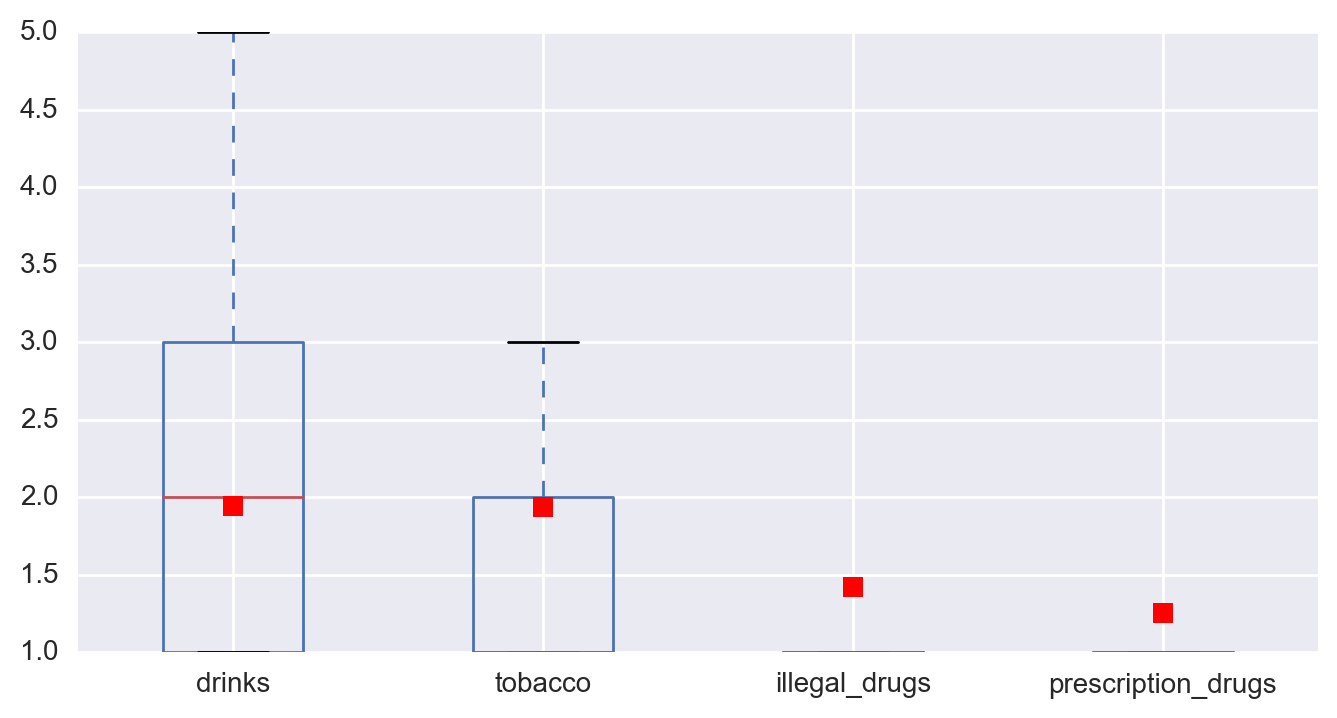

In [54]:
fig, ax = plt.subplots(figsize = (8, 4))
arradata[['drinks', 'tobacco', 'illegal_drugs', 'prescription_drugs']].plot.box(showmeans = True, ax = ax);

More detailed look into survey responses:

In [55]:
nRec = arradata.shape[0]

In [56]:
subst_count = pd.DataFrame(arradata['drinks'].value_counts()/ nRec)
subst_count['tobacco'] = arradata['tobacco'].value_counts()/ nRec
subst_count['illegal_drugs'] = arradata['illegal_drugs'].value_counts()/ nRec
subst_count['prescription_drugs'] = arradata['prescription_drugs'].value_counts()/ nRec

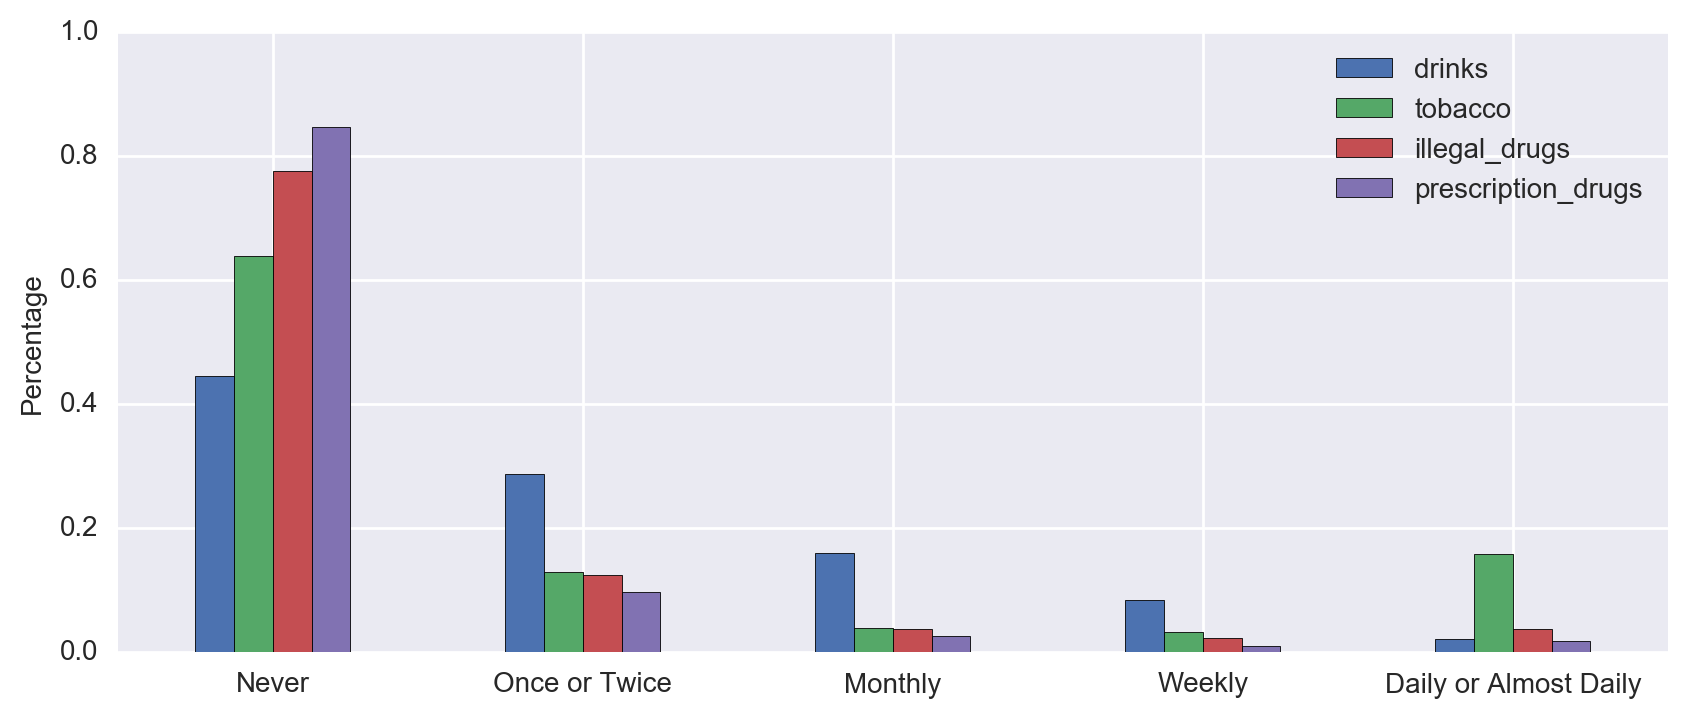

In [57]:
fig, ax = plt.subplots(figsize = (10, 4))
subst_count.plot.bar(ax = ax)
ax.set_xticklabels(['Never', 'Once or Twice', 'Monthly', 'Weekly', 'Daily or Almost Daily'],
                   rotation = 0, fontsize = 'small')
ax.set_ylim([0,1])
ax.set_ylabel('Percentage', fontsize = 'small');

I want nice, `ggplot`-looking plots, in which I plot one column vs. another, color by third (one could use `ggplot` for Python, but I wanna practice matplotlib):

In [131]:
def my_plot(df, x, y, label, width = 8, height = 4, marker = 'o', 
            ms = 7, fontsize = 12, linestyle = '', xlim = (0,0), ylim = (0,0), **args):
    groups = df.groupby(label)
    fig, ax = plt.subplots(figsize = (width, height))
    for name, group in groups:
        ax.plot(group[x], group[y], marker = marker, linestyle = linestyle, 
                ms = ms, label = name, **args)
    ax.set_xlabel(x, fontsize = fontsize)
    ax.set_ylabel(y, fontsize = fontsize)
    legend = ax.legend(frameon = False, bbox_to_anchor = (1.01, 0.99), loc = 2, borderaxespad = 0.)
    for label in legend.get_texts():
        label.set_fontsize(fontsize)
    if xlim != (0,0): ax.set_xlim([xlim[0], xlim[1]])
    if ylim != (0,0): ax.set_ylim([ylim[0], ylim[1]])
    plt.close()
    return fig

For example, let's see if there's any correlation between the popularity and activity (measured by `follow_ratio` and `mean_activity`) and BMI:

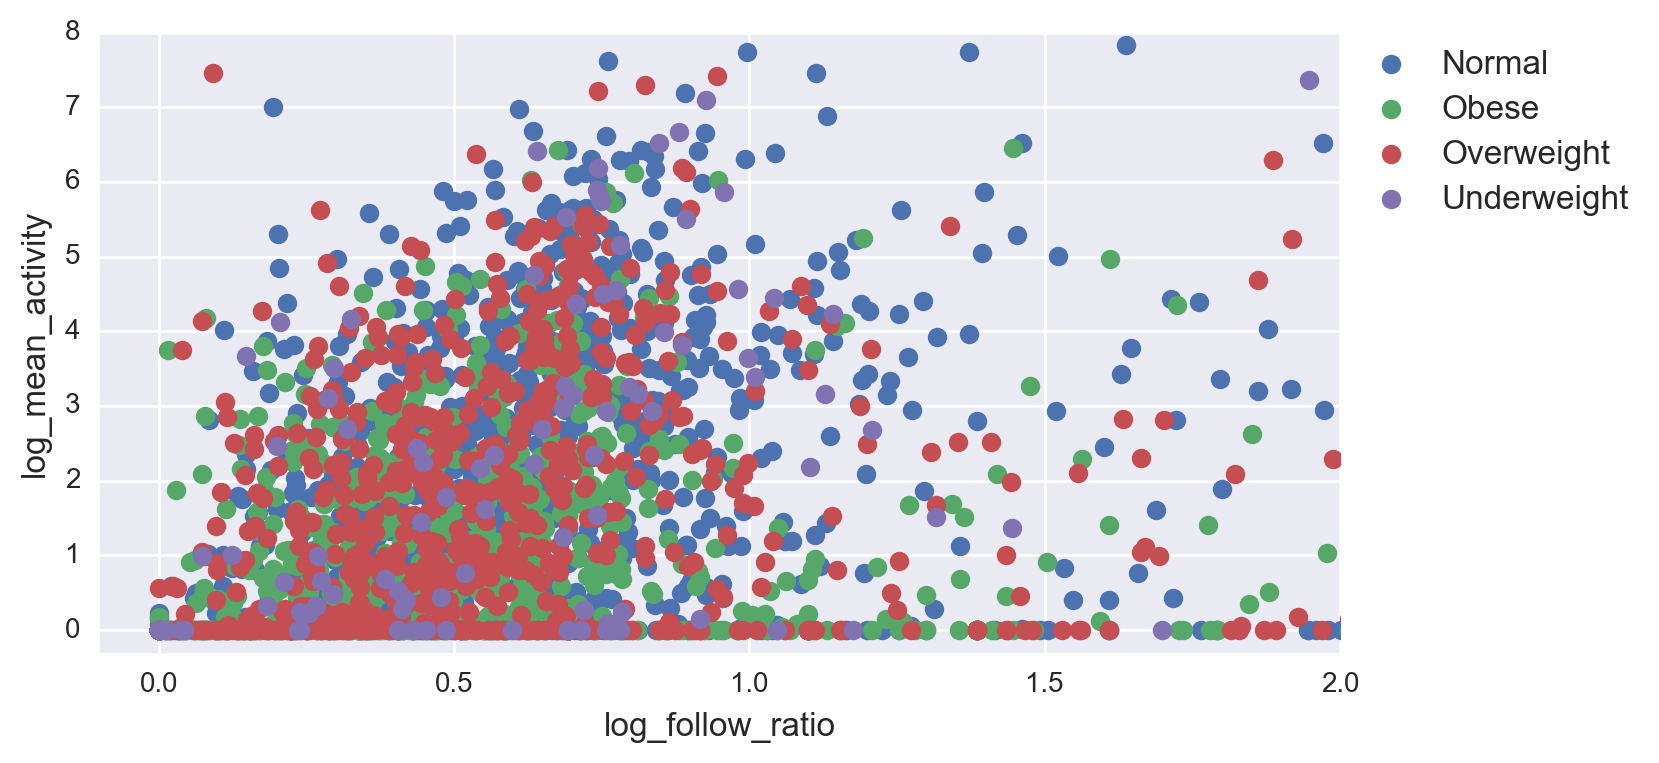

In [59]:
my_plot(arradata, x = 'log_follow_ratio', y = 'log_mean_activity', label = 'bmi_cat',
        xlim = (-0.1, 2), ylim = (-0.3, 8))

In [60]:
act_means = arradata['log_mean_activity'].groupby(arradata['bmi_cat']).mean()
act_stds = arradata['log_mean_activity'].groupby(arradata['bmi_cat']).std()
fol_means = arradata['log_follow_ratio'].groupby(arradata['bmi_cat']).mean()
fol_stds = arradata['log_follow_ratio'].groupby(arradata['bmi_cat']).std()

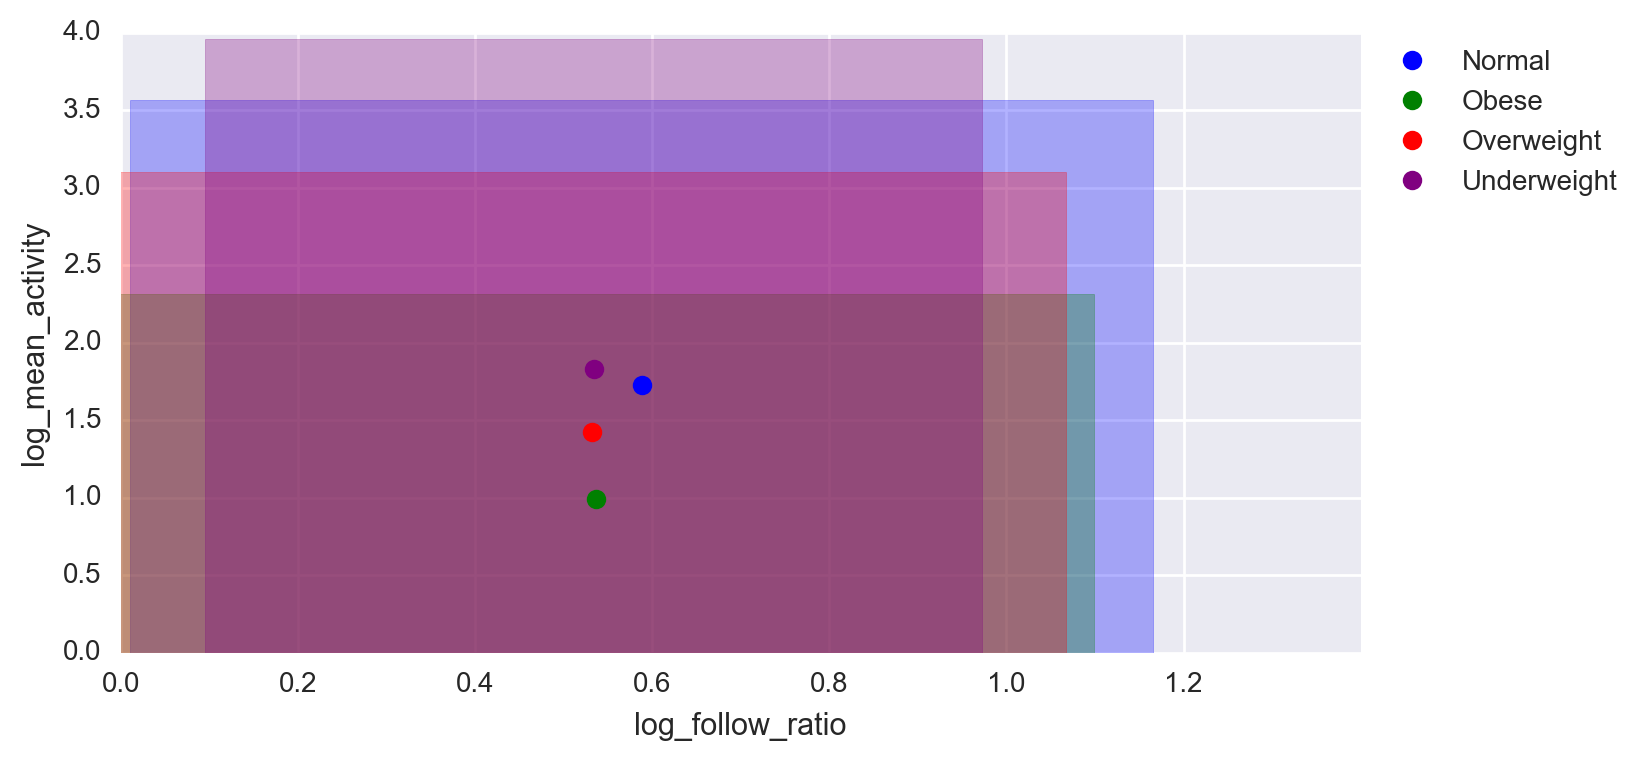

In [61]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.set_xlabel('log_follow_ratio')
ax.set_ylabel('log_mean_activity')
ax.set_xlim([0, 1.4])
ax.set_ylim([0, 4])
my_colors = ['b', 'g', 'r', 'purple']
for i in range(4):
    x_loc = fol_means[i] - fol_stds[i]
    y_loc = act_means[i] - act_stds[i]
    x_width = 2 * fol_stds[i]
    y_width = 2 * act_stds[i]
    ax.plot(fol_means[i], act_means[i], marker = 'o', linestyle = '', 
            label = act_means.index.tolist()[i], c = my_colors[i])
    ax.add_patch(plt.Rectangle((x_loc, y_loc), x_width, y_width, color = my_colors[i], alpha=0.3));
legend = ax.legend(frameon = False, bbox_to_anchor = (1.01, 0.99), loc = 2, borderaxespad = 0.)

How is the typical posting time dependent on age and magnetism?

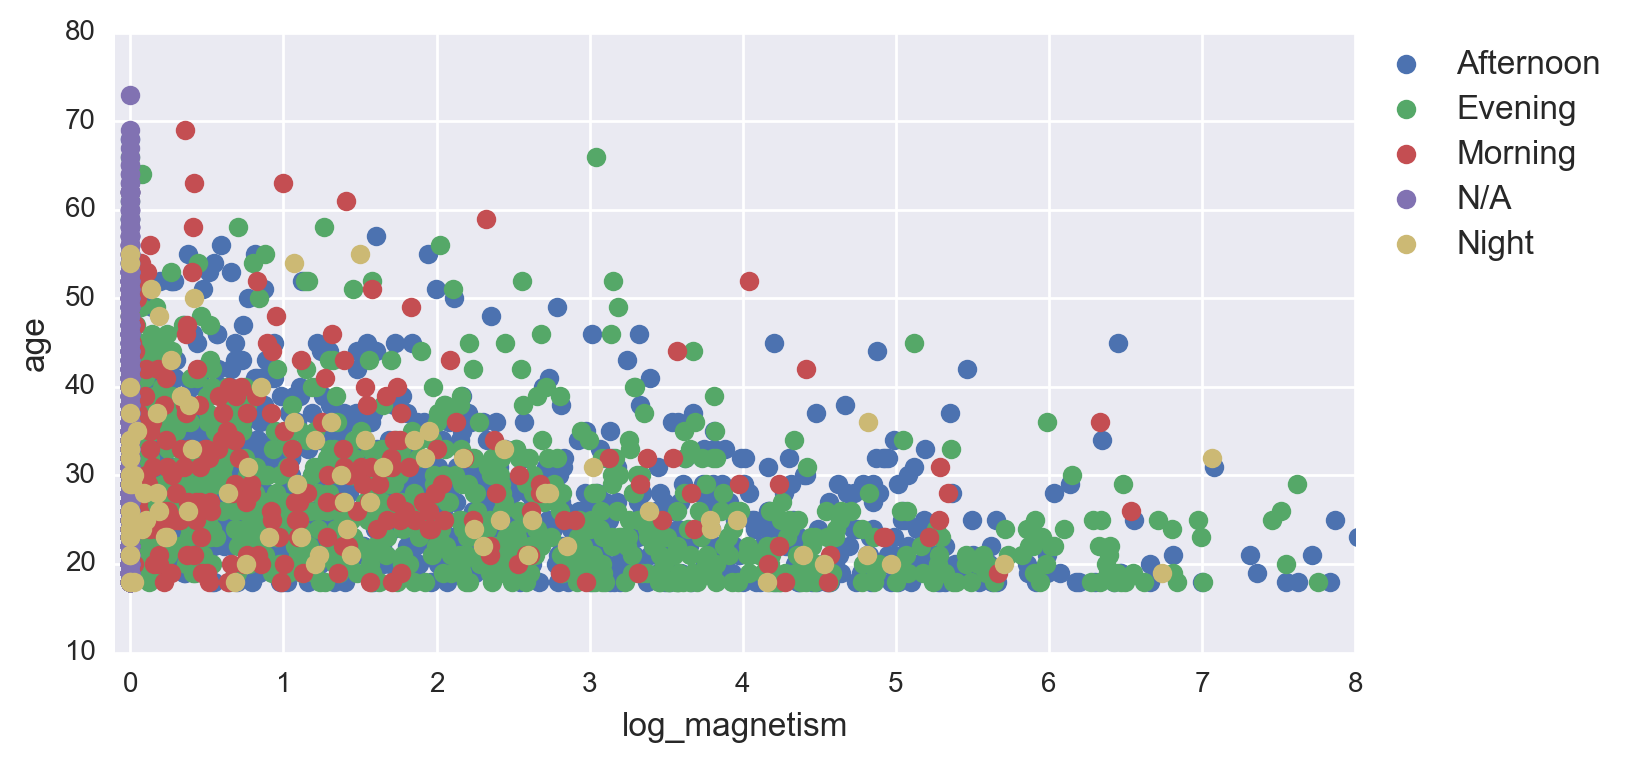

In [62]:
my_plot(arradata, x = 'log_magnetism', y = 'age', label = 'av_time_of_day', xlim = (-0.1, 8))

As expected, predicting outcome based on the features we have so far will be hard:

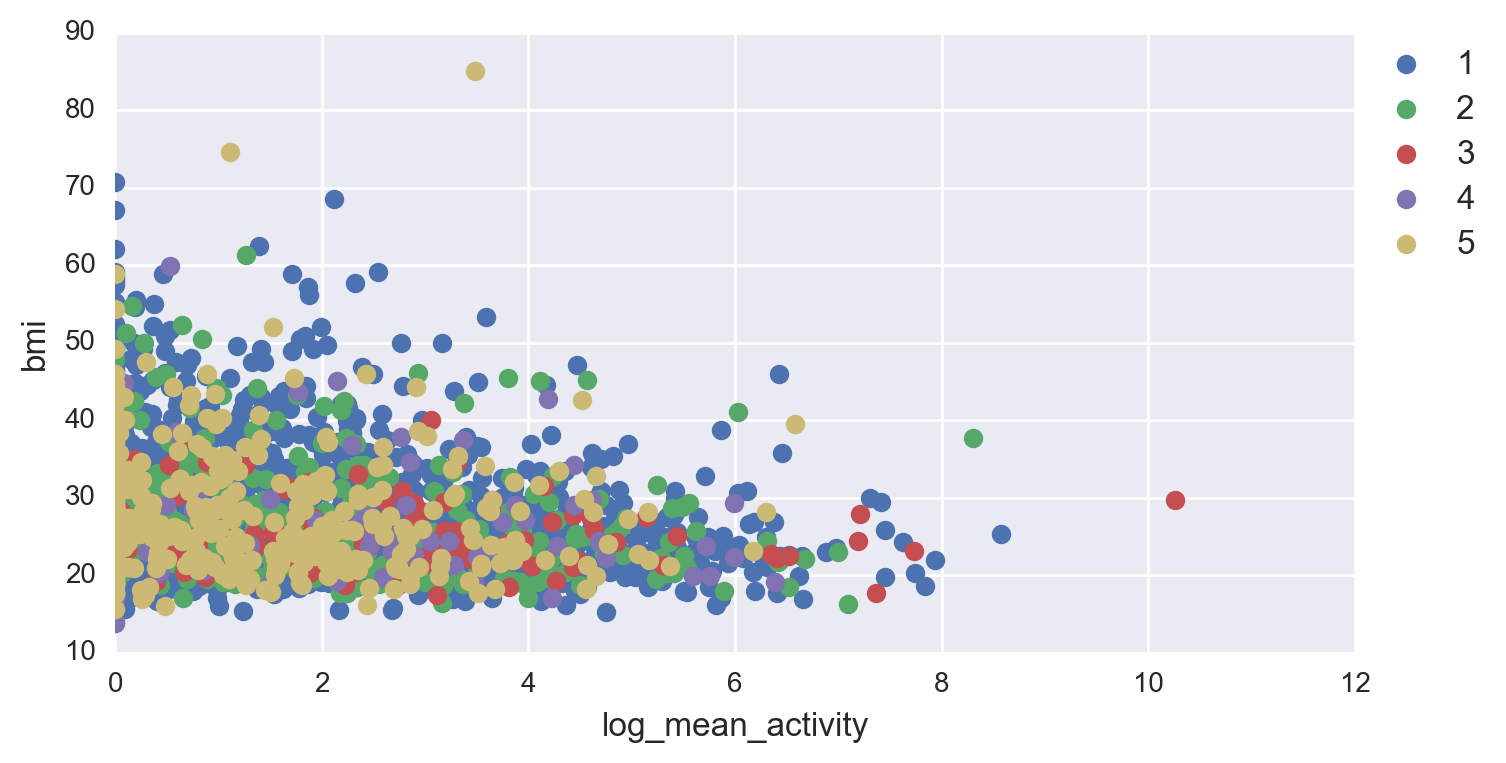

In [63]:
my_plot(arradata, x = 'log_mean_activity', y = 'bmi', label = 'tobacco')

---

# <a name="p2">2. Generate networks and SNA metrics</a>

## <a name="p21">2.1 Generate a single graph</a>

Concentrate on one particular user (later this can be embedded in a loop)

In [62]:
select_user_id = <redacted>

Find its username:

In [65]:
sql_query = (""" SELECT username FROM main_user 
            WHERE "userId" = '%s';""" % select_user_id)
username = pd.read_sql(sql_query, conn)['username'][0]
#username

Extract the list of all the ppl tagged in its photos:

In [66]:
sql_query = ("""
            SELECT username, photo_id, main_usersinphoto."userId"
            FROM main_usersinphoto
            JOIN main_instagrammedia 
            ON main_usersinphoto.photo_id = main_instagrammedia.id
            WHERE main_instagrammedia."userId" = '%s';""" % select_user_id)
tag_data = pd.read_sql(sql_query, conn)
#tag_data.head()

Remove the user (for now) from the tag data:

In [67]:
tag_data = tag_data[tag_data['username'] != username]

Extract the list of all the people in its network:

In [68]:
taggers = list(tag_data['username'].unique())
nNodes = len(taggers) + 1

Based on this, we initialize nNodes x nNodes weight matrix:

In [69]:
tag_matrix = np.array([0] * nNodes * nNodes).reshape((nNodes, nNodes))

For each of the users, add its position in the weight matrix to the tag_data DF:

In [72]:
tag_index = lambda user: taggers.index(user) + 1
tag_data['tag_index'] = tag_data[['username']].applymap(tag_index)['username']
#tag_data.head()

List of all the distinct photos:

In [73]:
photo_list = list(tag_data['photo_id'].unique())

For each photo, list of all the ppl (by tag_index) that are in it (adding a zero, for the central node):

In [74]:
tag_master = [[0] + list(tag_data[tag_data['photo_id'] == p]['tag_index']) for p in photo_list]
tag_master[0: min(5, len(tag_master) / 2)]

[[0, 1, 2, 3], [0, 2], [0, 4], [0, 5, 6, 2, 7, 8], [0, 9, 10]]

Convert this info into the weight matrix:

In [75]:
for t in tag_master:
    for i in range(len(t)):
        for j in range(i + 1, len(t)):
            tag_matrix[t[i], t[j]] = tag_matrix[t[i], t[j]] + 1

Use it to make a networkX graph:

In [76]:
G = nx.from_numpy_matrix(np.matrix(tag_matrix, dtype = [('weight', int)]))

Plot

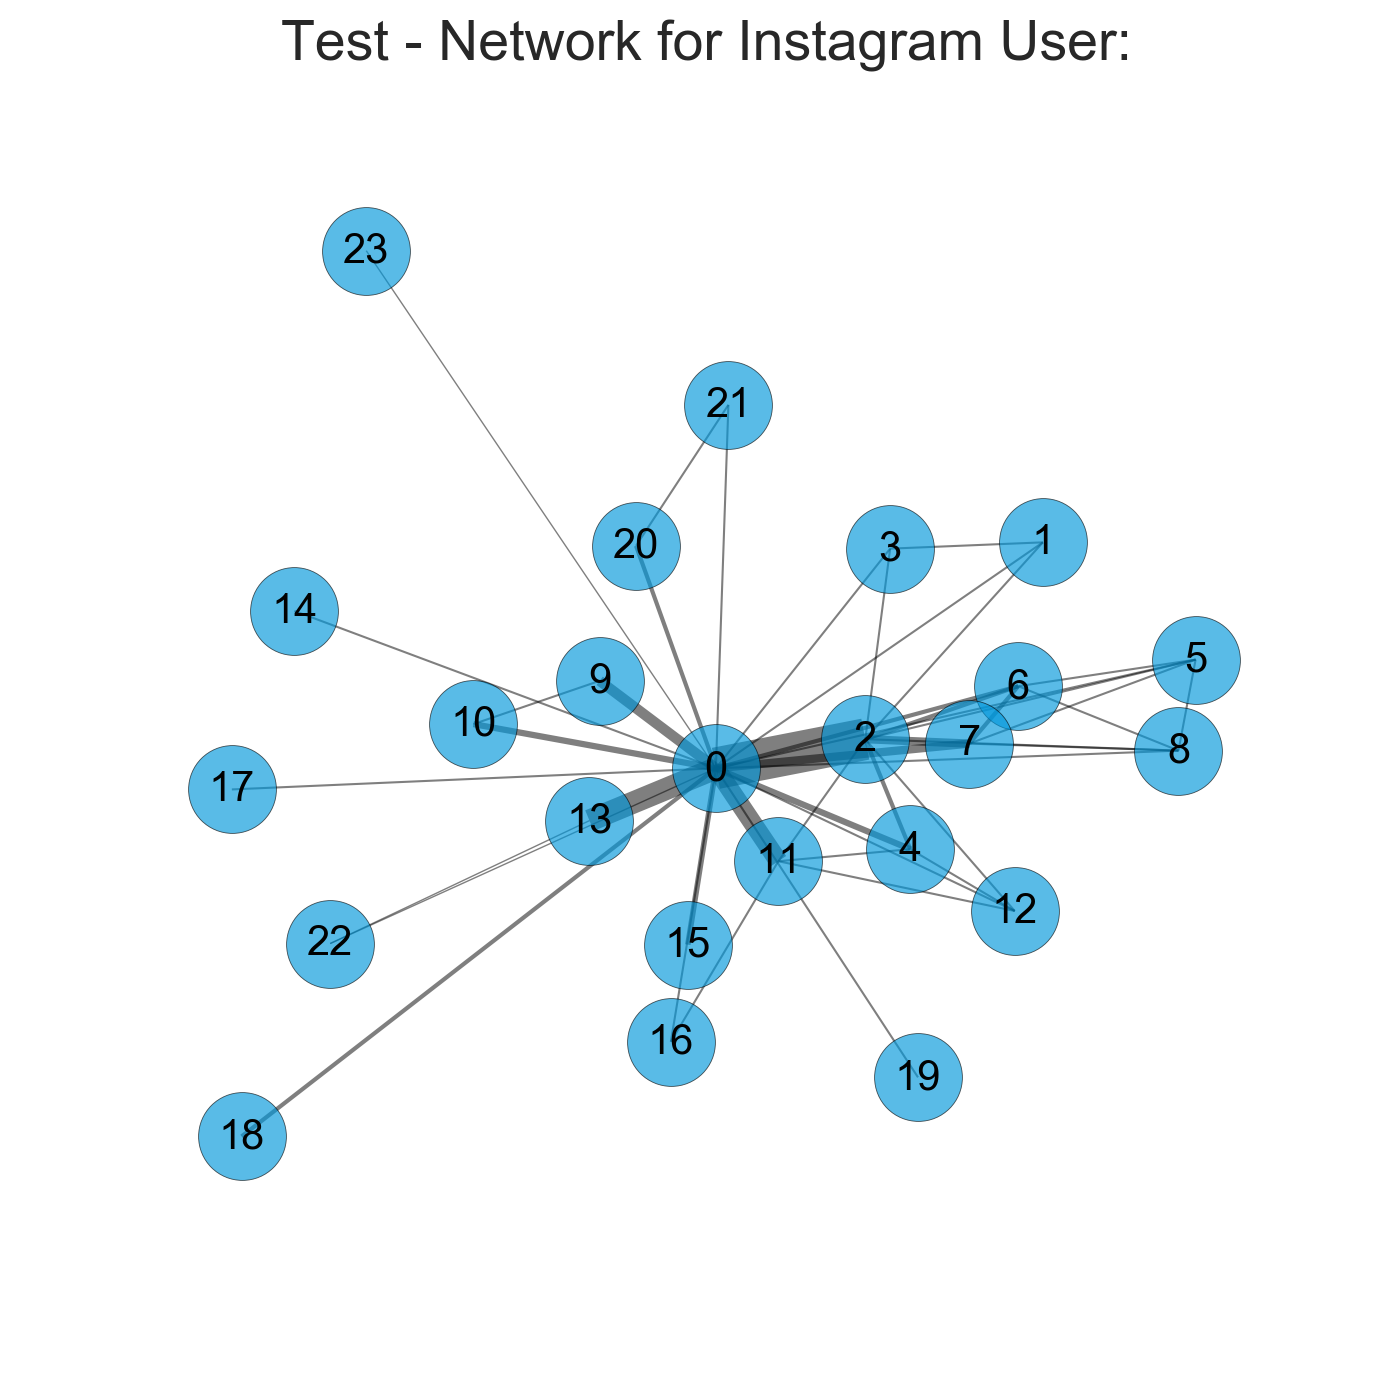

In [78]:
fac = 15. / float(np.amax(tag_matrix)) # So the edge widths are nicely scaled
edgeWidth = [fac * d['weight'] for (u, v, d) in G.edges(data = True)]
plt.rc('figure', figsize=(8, 8))
plt.axis('off')
plt.title('Test - Network for Instagram User: ', fontdict = {"fontsize": 20})
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=1000, alpha = 0.65, node_color = '#0097db')
nx.draw_networkx_labels(G, pos, font_size = 15, font_family = 'sans-serif')
nx.draw_networkx_edges(G, pos, width = edgeWidth, alpha = 0.5);

Now we can compute all kinds of SNA metrics, for example the average clustering coefficient:

In [79]:
nx.average_clustering(G)

0.6755471380471381

Including the weights, we get:

In [80]:
nx.average_clustering(G, weight = 'weight')

0.06124582279130764

This is really small since what we're calling the weight there is really 1 / weight, so to correct for that:

In [81]:
for u, v, d in G.edges(data = True): d['weight'] = 1. / np.float(d['weight'])

In [82]:
nx.average_clustering(G, weight = 'weight')

0.29436593869772626

New metrics introduced in version 8:

In [83]:
[nx.clustering(G, nodes = 0, weight = 'weight'),
nx.closeness_centrality(G, u = 0, distance = 'weight'),
nx.betweenness_centrality(G, weight = 'weight')[0],
G.size(weight = 'weight'),
nx.degree(G, nbunch = 0, weight = 'weight')]

[0.030637598538995496,
 4.247061337892712,
 0.8952569169960474,
 12.49884259259259,
 5.4155092592592595]

## <a name="p22">2.2 Generate graphs for all users</a>

Here we employ methods from the previous section to generate weight matrices in a loop for all users. Start with getting all the users:

In [84]:
sql_query = ("""
            SELECT main_instagrammedia."userId" user_id, photo_id, main_usersinphoto."userId" user_tagged, main_instagrammedia."createdTime" created_time
            FROM main_usersinphoto
            JOIN main_instagrammedia 
            ON main_usersinphoto.photo_id = main_instagrammedia.id
            """)
all_tag_data = pd.read_sql(sql_query, conn)
#all_tag_data.head()

In [85]:
sql_query = (""" 
             SELECT  main_user."userId" user_id, main_survey."createDate" create_date
             FROM main_survey 
             JOIN main_user
             ON main_user.survey_id = main_survey.id
             """)
all_survey_times = pd.read_sql(sql_query, conn)
#all_survey_times.head()

How many distinct users do we have:

In [86]:
users = list(all_tag_data['user_id'].unique())
len(users)

1487

Decide whether you want a weighted or a non-weighted graph (set this to `None` for a non-weighted network or `'weight'` for a weighted one).

In [87]:
my_weight = None

In [88]:
if my_weight == 'weight': 
    sna_filename = 'arra_sna_weighted.csv'
    sna_12_filename = 'arra_sna_weighted_12.csv'
else: 
    sna_filename = 'arra_sna_no_weight.csv'
    sna_12_filename = 'arra_sna_no_weight_12.csv'

Check if we've already calculated the metrics for some of the users:

In [89]:
does_sna_csv_exists = os.path.isfile(sna_filename) and os.path.isfile(sna_12_filename)
if does_sna_csv_exists == True:
    old_sna_df = pd.read_csv(sna_filename, index_col = 0)
    old_sna_12_df = pd.read_csv(sna_12_filename, index_col = 0)
    old_sna_df.index = old_sna_df.index.map(str)
    old_sna_12_df.index = old_sna_12_df.index.map(str)
    new_users = list(set(users) - set(old_sna_df.index.tolist()))
else:
    new_users = users
len(new_users)

15

This can take a while so display a nice progress bar:

In [90]:
prog_bar = FloatProgress(min = 0, max = len(new_users))
display(prog_bar)

SNA metrics we'll calculate (if adding or removing some here, make sure to do the same in the loop below, and delete the CSV file, as the DF from there and the DF computed won't be compatible)

In [91]:
sna_col_names = ['largest_clique', 'density', 'edge_count', 'average_clustering', 'assortativity',
                 'clique_count', 'transitivity', 'connected', 'connected_components', 'biconnected', 
                 'node_connectivity', 'edge_connectivity', 'average_connectivity', 'radius', 
                 'diameter','average_shortest_path', 'isolates', 'selfies_count', 'node_count',
                 'ego_clustering', 'ego_closeness_centrality', 'ego_betweenness_centrality', 
                 'graph_size', 'ego_degree']

In [92]:
sna_12_col_names = ['largest_clique_12', 'density_12', 'edge_count_12', 'average_clustering_12', 'assortativity_12',
                   'clique_count_12', 'transitivity_12', 'connected_12', 'connected_components_12', 'biconnected_12', 
                   'node_connectivity_12', 'edge_connectivity_12', 'average_connectivity_12', 'radius_12', 
                   'diameter_12','average_shortest_path_12', 'isolates_12', 'selfies_count_12', 'node_count_12',
                   'ego_clustering_12', 'ego_closeness_centrality_12', 'ego_betweenness_centrality_12', 
                   'graph_size_12', 'ego_degree_12']

Loop over them and for each user generate a tag network

In [98]:
def get_days_delta_alt(timestamp):
    utc_time = datetime.datetime.utcfromtimestamp(timestamp)
    cnt_time = utc_tz.localize(utc_time).astimezone(cnt_tz)
    delta = survey_time - cnt_time
    return delta.days

In [99]:
all_sna_metrics = []
all_sna_12_metrics = []

for u in new_users:
    tag_data = all_tag_data[all_tag_data['user_id'] == u][['photo_id', 'user_tagged', 'created_time']]
    selfies_count = sum(tag_data['user_tagged'] == u)
    tag_data = tag_data[tag_data['user_tagged'] != u]
    
    survey_time = all_survey_times[all_survey_times['user_id'] == u]['create_date'][0]
    survey_time = survey_time.to_datetime().astimezone(cnt_tz)
    tag_data['days_delta'] = tag_data[['created_time']].applymap(get_days_delta_alt)['created_time']
    tag_data_12 = tag_data[tag_data['days_delta'] <= 365].copy()
    
    if tag_data.shape[0] > 0:
        taggers = list(tag_data['user_tagged'].unique())
        nNodes = len(taggers) + 1
        tag_matrix = np.array([0] * nNodes * nNodes).reshape((nNodes, nNodes))
        tag_index = lambda user: taggers.index(user) + 1
        tag_data['tag_index'] = tag_data[['user_tagged']].applymap(tag_index)['user_tagged']
        photo_list = list(tag_data['photo_id'].unique())
        tag_master = [[0] + list(tag_data[tag_data['photo_id'] == p]['tag_index']) for p in photo_list]
        for t in tag_master:
            for i in range(len(t)):
                for j in range(i + 1, len(t)):
                    tag_matrix[t[i], t[j]] = tag_matrix[t[i], t[j]] + 1
        G = nx.from_numpy_matrix(np.matrix(tag_matrix, dtype = [('weight', int)]))
        for u1, v1, d1 in G.edges(data = True): d1['weight'] = 1. / np.float(d1['weight'])
   
        sna_metrics = [u,
            nx.graph_clique_number(G),
            nx.density(G),
            nx.number_of_edges(G),
            nx.average_clustering(G, weight = my_weight),
            nx.degree_assortativity_coefficient(G),
            nx.graph_number_of_cliques(G),
            nx.transitivity(G),
            nx.is_connected(G),
            nx.number_connected_components(G),
            nx.is_biconnected(G),
            nx.node_connectivity(G),
            nx.edge_connectivity(G),
            nx.average_node_connectivity(G),
            nx.radius(G),
            nx.diameter(G),
            nx.average_shortest_path_length(G, weight = my_weight),
            len(nx.isolates(G)),
            selfies_count,
            nx.number_of_nodes(G), 
            nx.clustering(G, nodes = 0, weight = my_weight), 
            nx.closeness_centrality(G, u = 0, distance = my_weight),
            nx.betweenness_centrality(G, weight = my_weight)[0],
            G.size(weight = my_weight),
            nx.degree(G, nbunch = 0, weight = my_weight)]

        all_sna_metrics.append(sna_metrics)

    if tag_data_12.shape[0] > 0:
        taggers = list(tag_data_12['user_tagged'].unique())
        nNodes = len(taggers) + 1
        tag_matrix = np.array([0] * nNodes * nNodes).reshape((nNodes, nNodes))
        tag_index = lambda user: taggers.index(user) + 1
        tag_data_12['tag_index'] = tag_data_12[['user_tagged']].applymap(tag_index)['user_tagged']
        photo_list = list(tag_data_12['photo_id'].unique())
        tag_master = [[0] + list(tag_data_12[tag_data_12['photo_id'] == p]['tag_index']) for p in photo_list]
        for t in tag_master:
            for i in range(len(t)):
                for j in range(i + 1, len(t)):
                    tag_matrix[t[i], t[j]] = tag_matrix[t[i], t[j]] + 1
        G = nx.from_numpy_matrix(np.matrix(tag_matrix, dtype = [('weight', int)]))
        for u1, v1, d1 in G.edges(data = True): d1['weight'] = 1. / np.float(d1['weight'])
   
        sna_metrics = [u,
            nx.graph_clique_number(G),
            nx.density(G),
            nx.number_of_edges(G),
            nx.average_clustering(G, weight = my_weight),
            nx.degree_assortativity_coefficient(G),
            nx.graph_number_of_cliques(G),
            nx.transitivity(G),
            nx.is_connected(G),
            nx.number_connected_components(G),
            nx.is_biconnected(G),
            nx.node_connectivity(G),
            nx.edge_connectivity(G),
            nx.average_node_connectivity(G),
            nx.radius(G),
            nx.diameter(G),
            nx.average_shortest_path_length(G, weight = my_weight),
            len(nx.isolates(G)),
            selfies_count,
            nx.number_of_nodes(G), 
            nx.clustering(G, nodes = 0, weight = my_weight), 
            nx.closeness_centrality(G, u = 0, distance = my_weight),
            nx.betweenness_centrality(G, weight = my_weight)[0],
            G.size(weight = my_weight),
            nx.degree(G, nbunch = 0, weight = my_weight)]

        all_sna_12_metrics.append(sna_metrics)        
    prog_bar.value += 1

Convert the results into a DF and concatenate with the old SNA DF, and export to CSV:

In [100]:
sna_df = pd.DataFrame(all_sna_metrics, columns = ['user_id'] + sna_col_names)
sna_df.index = sna_df['user_id']
del sna_df.index.name
sna_df = sna_df.drop('user_id', axis = 1)

In [101]:
sna_12_df = pd.DataFrame(all_sna_12_metrics, columns = ['user_id'] + sna_12_col_names)
sna_12_df.index = sna_12_df['user_id']
del sna_12_df.index.name
sna_12_df = sna_12_df.drop('user_id', axis = 1)

In [102]:
if does_sna_csv_exists == True:
    sna_12_df = pd.concat([old_sna_12_df, sna_12_df])
    sna_df = pd.concat([old_sna_df, sna_df])
sna_df.to_csv(sna_filename)
sna_12_df.to_csv(sna_12_filename)

## <a name="p23">2.3 Implementing the social shift model</a>

We'll implement it in 1-day increments, looking over the previous 12 months from the date of submitting survey, with a variable forgetfullness rate

In [103]:
f_rate = 1. / 365.

Let's do it first for one user:

In [104]:
select_user_id = <redacted>

First we get the time this user filled out the survey and convert it to `datetime` format:

In [105]:
sql_query = (""" 
             SELECT main_survey."createDate"
             FROM main_survey 
             JOIN main_user
             ON main_user.survey_id = main_survey.id
             WHERE main_user."userId" = '%s'
             """% select_user_id)
survey_time = pd.read_sql(sql_query, conn)['createDate'][0]
survey_time = survey_time.to_datetime().astimezone(cnt_tz)
survey_time

datetime.datetime(2016, 10, 7, 15, 10, 34, 859676, tzinfo=<DstTzInfo 'US/Central' CDT-1 day, 19:00:00 DST>)

Now we get the list of all the tags for the user, together with the time they were made in the timestamp format:

In [107]:
sql_query = ("""
            SELECT username, photo_id, main_usersinphoto."userId", main_instagrammedia."createdTime"
            FROM main_usersinphoto
            JOIN main_instagrammedia ON main_usersinphoto.photo_id = main_instagrammedia.id
            WHERE main_instagrammedia."userId" = '%s';""" % select_user_id)
tag_data = pd.read_sql(sql_query, conn)
#tag_data.head()

Find the time the first tag was made and call that `t = 0`, and convert it to `datetime` format:

In [108]:
first_tag_timestamp = tag_data['createdTime'].min()
utc_time = datetime.datetime.utcfromtimestamp(first_tag_timestamp)
first_tag_time = utc_tz.localize(utc_time).astimezone(cnt_tz)
first_tag_time

datetime.datetime(2013, 6, 21, 17, 29, 25, tzinfo=<DstTzInfo 'US/Central' CDT-1 day, 19:00:00 DST>)

Now convert the times the tags were made into `datetime` and subtract it from the first tag's time, and extract the difference in days:

In [110]:
def get_days_delta(timestamp):
    utc_time = datetime.datetime.utcfromtimestamp(timestamp)
    cnt_time = utc_tz.localize(utc_time).astimezone(cnt_tz)
    delta = cnt_time - first_tag_time
    return delta.days
tag_data['days_delta'] = tag_data[['createdTime']].applymap(get_days_delta)['createdTime']
#tag_data.head()

We'll be monitoring the activity of users within one year from filling out the survey, so find the that time (in the ref. frame where `t = 0` is the time of the first tag), and the time one year before that:

In [111]:
t_end = (survey_time - first_tag_time).days
t_start = t_end - 365
t_end

1203

Find all the days on which new tags are being made to speed up the calculation:

In [112]:
all_tag_days = tag_data['days_delta'].unique()
tag_days = all_tag_days[all_tag_days >= t_start]
tag_days

array([1177, 1165, 1145, 1141, 1122, 1090, 1071, 1064, 1042, 1030,  982,
        968,  963,  948,  933,  913,  897,  896,  890,  862,  842])

For each day between and beginning and the start time, calculate the effective degree of the central node, by looking only at the tags made before that time and calculating the strengths using that formula:

In [113]:
deg_list = []
relevant_tags = tag_data['days_delta'][tag_data['days_delta'] <= t_start]
for t in range(t_start, t_end + 1):
    if t in tag_days:
        relevant_tags = tag_data['days_delta'][tag_data['days_delta'] <= t]
    deg_local = sum(np.exp(- (t - relevant_tags) * f_rate))
    deg_list.append(deg_local)
[np.mean(deg_list), np.std(deg_list)]

[79.905867490417961, 11.825680868877857]

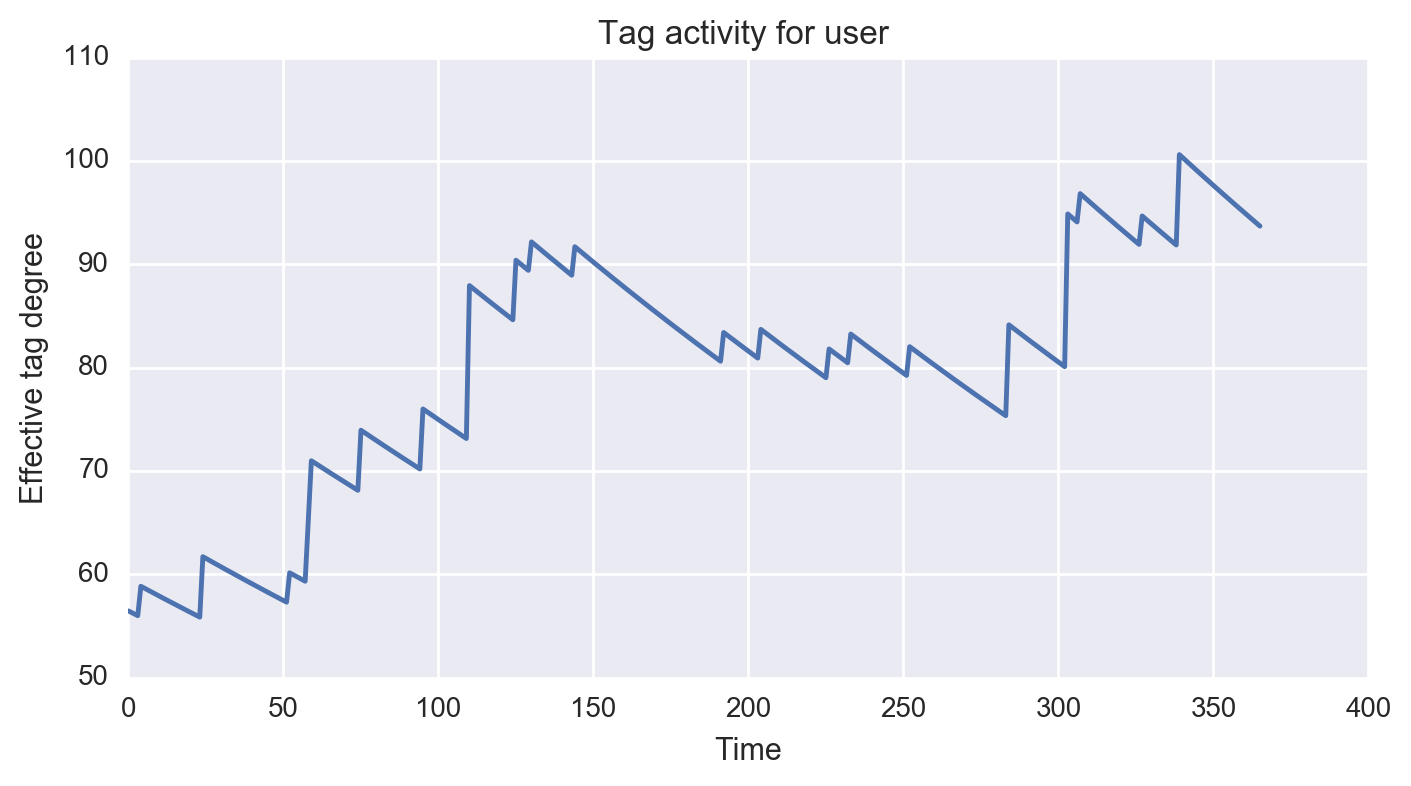

In [115]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(deg_list)
ax.set_xlabel('Time')
ax.set_ylabel('Effective tag degree')
ax.set_title('Tag activity for user ');

Now let's put this all in a loop and calculate the means and standard deviations for all the users with pics, similarly how we did it before with the other SNA metrics (note that if you change the forgetfullness rate, you need to delete `arra_tag.csv`)

In [116]:
f_rate = 1. / 30.

In [117]:
sql_query = ("""
            SELECT main_instagrammedia."userId" user_id, main_instagrammedia."createdTime" created_time
            FROM main_usersinphoto
            JOIN main_instagrammedia 
            ON main_usersinphoto.photo_id = main_instagrammedia.id
            """)
all_tag_data = pd.read_sql(sql_query, conn)
#all_tag_data.head()

In [118]:
sql_query = (""" 
             SELECT  main_user."userId" user_id, main_survey."createDate" create_date
             FROM main_survey 
             JOIN main_user
             ON main_user.survey_id = main_survey.id
             """)
all_survey_times = pd.read_sql(sql_query, conn)

In [119]:
users = list(all_tag_data['user_id'].unique())
len(users)

1487

In [120]:
does_tag_csv_exists = os.path.isfile('arra_tag.csv')
if does_tag_csv_exists == True:
    old_tag_df = pd.read_csv('arra_tag.csv', index_col = 0)
    old_tag_df.index = old_tag_df.index.map(str)
    new_users = list(set(users) - set(old_tag_df.index.tolist()))
else:
    new_users = users
len(new_users)

4

In [121]:
prog_bar = FloatProgress(min = 0, max = len(new_users))
display(prog_bar)

In [122]:
all_deg_res = []
for u in new_users:
    tag_data = all_tag_data[all_tag_data['user_id'] == u]
    first_tag_timestamp = tag_data['created_time'].min()
    utc_time = datetime.datetime.utcfromtimestamp(first_tag_timestamp)
    first_tag_time = utc_tz.localize(utc_time).astimezone(cnt_tz)
    tag_delta = tag_data[['created_time']].applymap(get_days_delta)['created_time']
    survey_time = all_survey_times[all_survey_times['user_id'] == u]['create_date'][0]
    survey_time = survey_time.to_datetime().astimezone(cnt_tz)
    t_end = (survey_time - first_tag_time).days
    t_start = t_end - 365
    all_tag_days = tag_delta.unique()
    tag_days = all_tag_days[all_tag_days >= t_start]
 
    deg_list = []
    relevant_tags = tag_delta[tag_delta <= t_start]
    for t in range(t_start, t_end + 1):
        if t in tag_days:
            relevant_tags = tag_delta[tag_delta <= t]
        deg_local = sum(np.exp(- (t - relevant_tags) * f_rate))
        deg_list.append(deg_local)

    deg_res = [u, np.mean(deg_list), np.std(deg_list)]
    all_deg_res.append(deg_res)      
    prog_bar.value += 1

In [123]:
tag_df = pd.DataFrame(all_deg_res, columns = ['user_id', 'deg_mean', 'deg_std'])
tag_df.index = tag_df['user_id']
del tag_df.index.name
tag_df = tag_df.drop('user_id', axis = 1)

In [124]:
if does_tag_csv_exists == True:
    tag_df = pd.concat([old_tag_df, tag_df])
tag_df.to_csv('arra_tag.csv')

Now add these to the main dataframe and take logs of them:

In [125]:
arradata = pd.merge(arradata, tag_df, left_index = True, right_index = True, how = 'left')

In [126]:
arradata['log_rel_deg'] = np.log(arradata['deg_std'] / arradata['deg_mean'] + 1)
arradata = arradata.fillna({'deg_mean': 0, 'deg_std': 0, 'log_rel_deg': 0})
arradata['log_deg_mean'] = np.log(arradata['deg_mean'] + 1)
arradata['log_deg_std'] = np.log(arradata['deg_std'] + 1)

A cheap way of exploring simple correlations:

In [127]:
#x_choice = ['rel_deg','log_deg_std']
#y_choice = ['log_follow_ratio', 'log_magnetism', 'log_mean_activity']
#label_choice = ['drinks', 'tobacco', 'illegal_drugs', 'prescription_drugs',
#                'dichot_drinks', 'dichot_tobacco', 'dichot_illegal_drugs', 'dichot_prescription_drugs']
#cnt = 1
#for my_x in x_choice:
#    for my_y in y_choice:
#        for my_label in label_choice:
#            this_pic = my_plot(arradata_later, x = my_x, y = my_y, label = my_label)
#            this_pic.savefig('fig'+ str(cnt) + '.pdf', bbox_inches = 'tight', pad_inches = 0)
#            cnt = cnt + 1

For example, the if we look at the tobacco use:

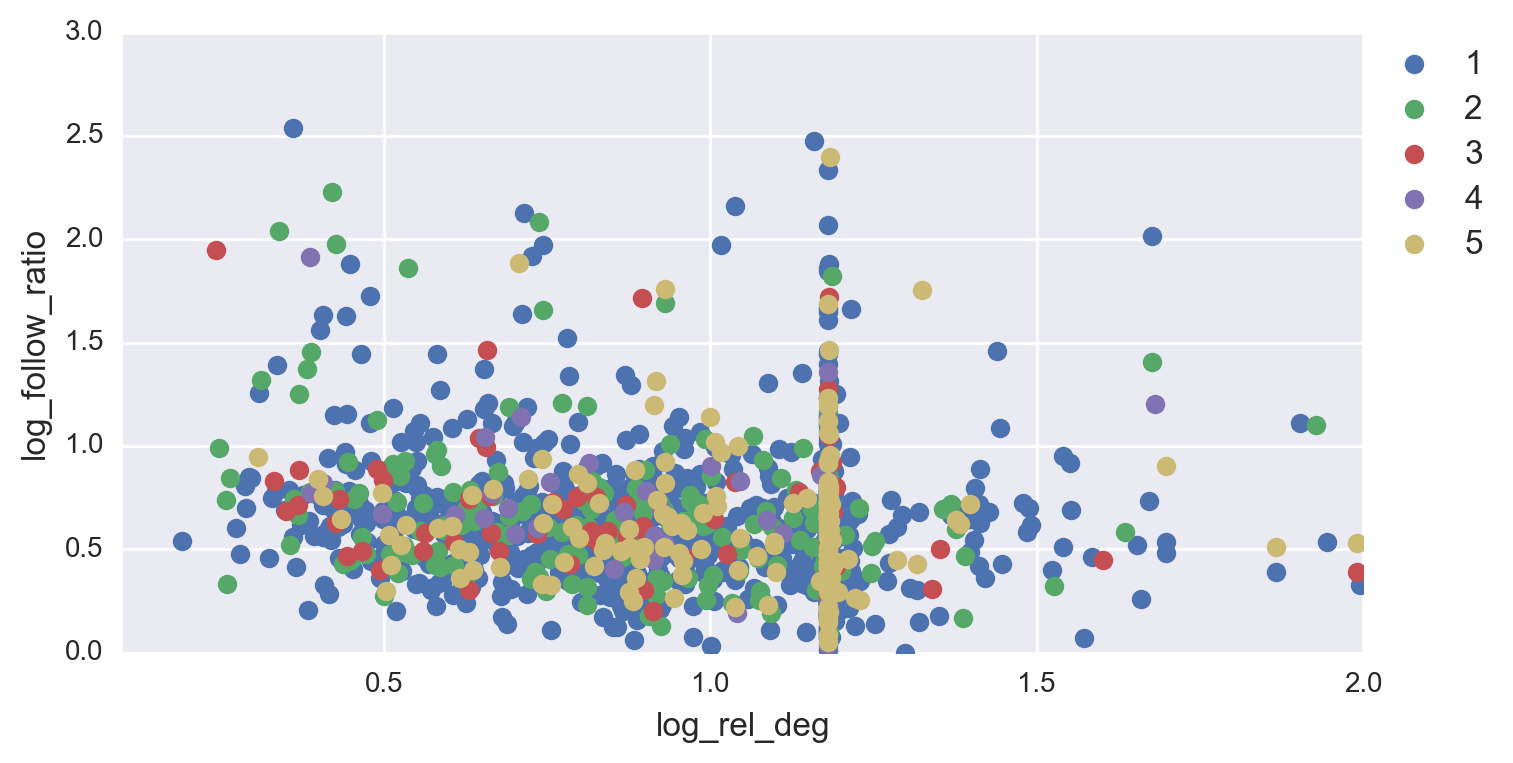

In [132]:
my_plot(arradata, x = 'log_rel_deg', y = 'log_follow_ratio', label = 'tobacco', 
        xlim = (0.1, 2), ylim = (0, 3))

## <a name="p24">2.4 Clean up SNA data</a>

Check if there's any NA values:

In [133]:
na_cols_ind = [sna_df[c].isnull().any() for c in sna_df.columns.tolist()]
na_cols = sna_df.columns[na_cols_ind].tolist()
na_cols

['assortativity']

In [134]:
na_cols_12_ind = [sna_12_df[c].isnull().any() for c in sna_12_df.columns.tolist()]
na_cols_12 = sna_12_df.columns[na_cols_12_ind].tolist()
na_cols_12

['assortativity_12']

It's generally assortativity, as it needs a nontrivial structure to define the correlation coefficient. I'm not sure about this, but I'll replace the missing values with 0.0, indicating a non-assortative structure.

In [135]:
sna_df = sna_df.fillna({'assortativity': 0.0})
sna_12_df = sna_12_df.fillna({'assortativity': 0.0})

Merge the SNA DF with the main dataset:

In [136]:
arradata = pd.merge(arradata, sna_df, left_index = True, right_index = True, how = 'left')
arradata = pd.merge(arradata, sna_12_df, left_index = True, right_index = True, how = 'left')

Fill NA values in SNA metrics, due to non existent tag network: formally this is equivalent to an edge-less network with a single node (note if you modify the SNA metrics, this also needs to be modified):

In [137]:
G = nx.Graph()
G.add_node(0)

sna_trivial = [
    nx.graph_clique_number(G),
    nx.density(G),
    nx.number_of_edges(G),
    nx.average_clustering(G),
    0.0, #nx.degree_assortativity_coefficient(G), same as before
    nx.graph_number_of_cliques(G),
    nx.transitivity(G),
    nx.is_connected(G),
    nx.number_connected_components(G),
    nx.is_biconnected(G),
    nx.node_connectivity(G),
    nx.edge_connectivity(G),
    nx.average_node_connectivity(G),
    nx.radius(G),
    nx.diameter(G),
    0,#nx.average_shortest_path_length(G), although it's formally infinite...
    len(nx.isolates(G)),
    0, # Selfies count
    nx.number_of_nodes(G),
    nx.clustering(G, nodes = 0), 
    nx.closeness_centrality(G, u = 0),
    nx.betweenness_centrality(G)[0],
    G.size(),
    nx.degree(G, nbunch = 0)]

print sna_trivial

[1, 0.0, 0, 0.0, 0.0, 1, 0.0, True, 1, False, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0.0, 0.0, 0.0, 0, 0]


In [148]:
sna_na_dict = {sna_col_names[i]:sna_trivial[i] for i in range(len(sna_trivial))}
arradata = arradata.fillna(sna_na_dict)
sna_12_na_dict = {sna_12_col_names[i]:sna_trivial[i] for i in range(len(sna_trivial))}
arradata = arradata.fillna(sna_12_na_dict)
arradata.isnull().values.any()

False

Add selfie percentage:

In [149]:
arradata['selfies_percentage'] = arradata['selfies_count'] / arradata['media']
arradata = arradata.fillna({'selfies_percentage': 0})
arradata.isnull().values.any()

False

Check for zero variance SNA metrics and remove them:

In [150]:
sna_loc_start = list(arradata.columns).index('largest_clique')
sna_loc_end = arradata.shape[1]

In [151]:
trivial_cols_index = []
for i in range(sna_loc_start, sna_loc_end):
    if len(arradata.ix[:, i].unique()) == 1: trivial_cols_index.append(i)
trivial_cols = [list(arradata.columns)[index] for index in trivial_cols_index]
trivial_cols

['connected',
 'connected_components',
 'connected_12',
 'connected_components_12']

In [152]:
ad_cleaned = arradata.drop(trivial_cols, axis = 1)

Find perfectly correlated columns and remove them:

In [153]:
sna_corr = ad_cleaned.ix[:, sna_loc_start:].corr()

In [154]:
corrs = []
for i in range(sna_corr.shape[0]):
    ones = sna_corr.ix[i][np.abs(sna_corr.ix[i]) == 1.0].index.tolist()
    ones_ind = [sna_corr.columns.tolist().index(o) for o in ones]
    if (len(ones_ind) > 1) and ones_ind not in corrs: corrs.append(ones_ind)
corrs_labels = [[sna_corr.columns.tolist()[a] for a in c] for c in corrs]
corrs_labels

[['edge_count', 'graph_size'],
 ['radius', 'isolates', 'ego_closeness_centrality'],
 ['node_count', 'ego_degree'],
 ['edge_count_12', 'graph_size_12'],
 ['radius_12', 'isolates_12', 'ego_closeness_centrality_12'],
 ['node_count_12', 'ego_degree_12']]

In [155]:
for l in corrs_labels:
    ad_cleaned = ad_cleaned.drop(l[1:], axis = 1)

These are the nontrivial SNA metrics:

In [157]:
ad_cleaned.reset_index().ix[:, sna_loc_start:].head()

,log_deg_std,largest_clique,density,edge_count,average_clustering,assortativity,clique_count,transitivity,biconnected,node_connectivity,...,edge_connectivity_12,average_connectivity_12,radius_12,diameter_12,average_shortest_path_12,selfies_count_12,node_count_12,ego_clustering_12,ego_betweenness_centrality_12,selfies_percentage
0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000,False,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.000000
1,0.000000,1.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000,False,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.000000
2,0.329874,5.0,0.466667,21.0,0.866667,-0.649038,5.0,0.515152,True,2.0,...,1.0,1.000000,1.0,1.0,1.000000,6.0,2.0,0.000000,0.000000,0.014388
3,0.000110,7.0,0.495238,52.0,0.872139,-0.249118,4.0,0.720994,True,2.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.000000
4,1.315782,10.0,0.730769,57.0,0.910567,-0.296324,4.0,0.873494,True,2.0,...,7.0,9.018182,1.0,2.0,1.054545,0.0,11.0,0.933333,0.009524,0.000000


Out of the nontrivial columns, let's look at which pairs of features are strongly correlated:

In [158]:
full_corr = ad_cleaned.corr()
all_cols = full_corr.columns.tolist()
corr_cols = []
for col in all_cols:
    top_corr = full_corr[col][abs(full_corr[col]) > 0.8].sort_values(ascending = False)
    if len(top_corr) > 1: 
        if ((top_corr.index[1], col) in corr_cols) == False:
            corr_cols.append((col, top_corr.index[1]))
corr_cols

[('weight', 'bmi'),
 ('log_mean_activity', 'log_magnetism'),
 ('deg_mean', 'deg_std'),
 ('log_rel_deg', 'radius'),
 ('log_deg_mean', 'log_deg_std'),
 ('largest_clique', 'average_connectivity'),
 ('density', 'log_rel_deg'),
 ('edge_count', 'node_count'),
 ('average_clustering', 'transitivity'),
 ('assortativity', 'diameter'),
 ('clique_count', 'node_count'),
 ('node_connectivity', 'edge_connectivity'),
 ('radius', 'average_shortest_path'),
 ('diameter', 'average_shortest_path'),
 ('selfies_count', 'selfies_count_12'),
 ('ego_clustering', 'transitivity'),
 ('ego_betweenness_centrality', 'diameter'),
 ('largest_clique_12', 'average_connectivity_12'),
 ('density_12', 'radius_12'),
 ('edge_count_12', 'node_count_12'),
 ('average_clustering_12', 'transitivity_12'),
 ('assortativity_12', 'diameter_12'),
 ('clique_count_12', 'node_count_12'),
 ('biconnected_12', 'density_12'),
 ('node_connectivity_12', 'edge_connectivity_12'),
 ('radius_12', 'average_shortest_path_12'),
 ('diameter_12', 'avera

A lot of these are trivial, but it's interesting that the log of the relative degree deviation is correlated to the density of tag graphs:

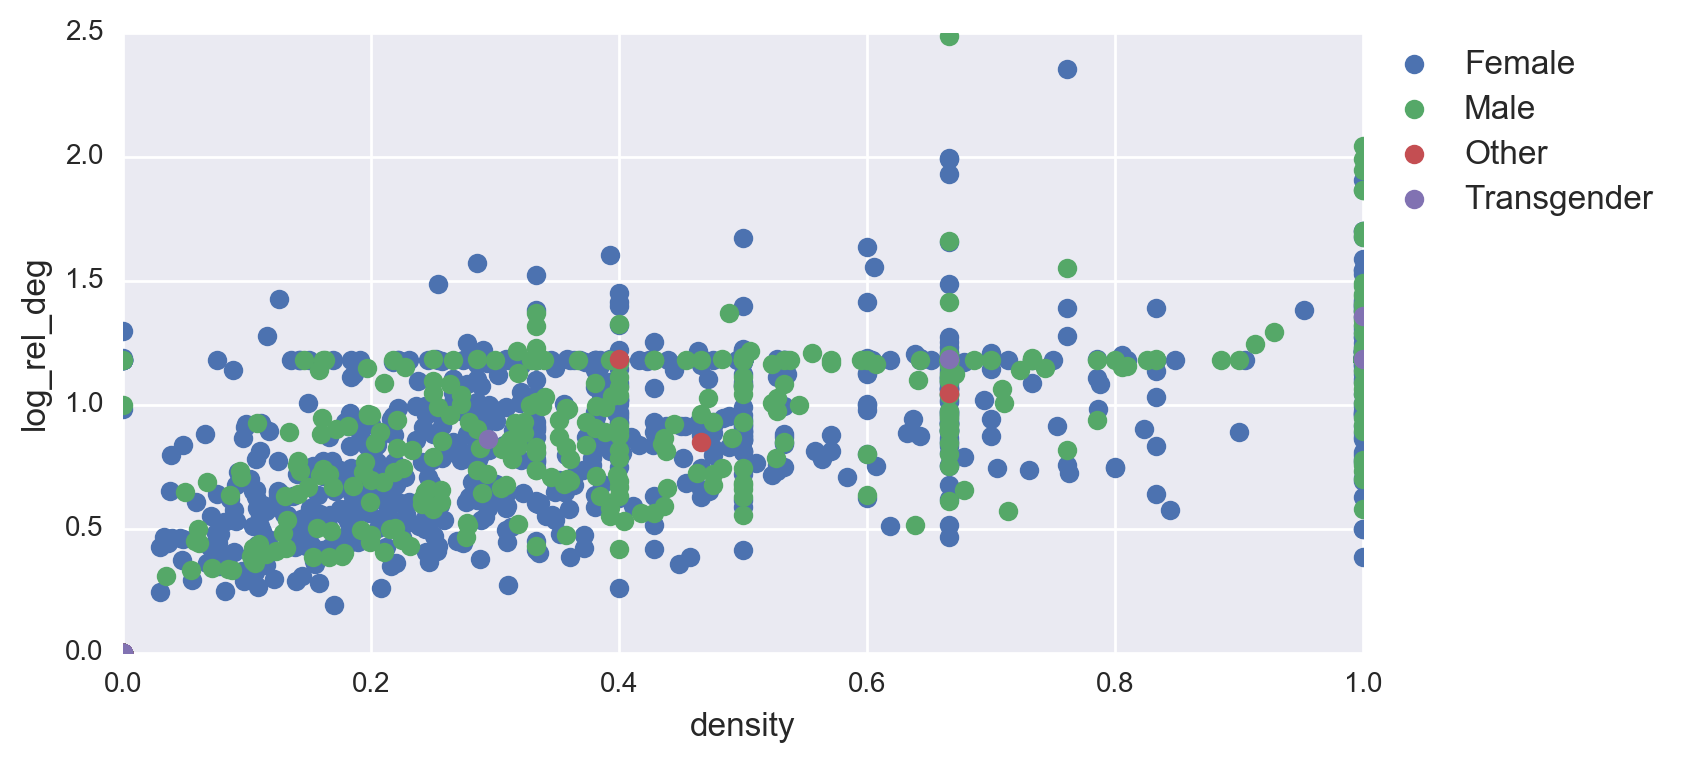

In [159]:
my_plot(ad_cleaned, x = 'density', y = 'log_rel_deg', label = 'gender')

Close connection:

In [160]:
conn.close()

---

# <a name="p3">3. Prediction</a>

In [161]:
import sklearn.metrics
from scipy import stats
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA

## <a name="p31">3.1 Feature subselection and preprocessing</a>

Dichotomize responses for a first stab at classification:

In [162]:
ad_cleaned['dichot_tobacco'] = np.where(ad_cleaned['tobacco'] > 1, 1, 0)
ad_cleaned['dichot_drinks'] = np.where(ad_cleaned['drinks'] > 1, 1, 0)
ad_cleaned['dichot_illegal_drugs'] = np.where(ad_cleaned['illegal_drugs'] > 1, 1, 0)
ad_cleaned['dichot_prescription_drugs'] = np.where(ad_cleaned['prescription_drugs'] > 1, 1, 0)

Decide if you want to keep the early users whose answers to the new questions in the extended survey we had to impute:

In [163]:
all_users = ad_cleaned.index.tolist()
late_users = list(set(all_users) - set(early_users))
considered_users = all_users

In [164]:
ad_cleaned_red = ad_cleaned.ix[considered_users]

Remove some of the features from the main DF: (comment out classes of features you wanna include)

In [165]:
remove_columns = ['drinks','tobacco','illegal_drugs','prescription_drugs','magnetism','follow_ratio',
                  'bmi_cat', 'health_score', 'social_shift', 'deg_mean', 'deg_std', 'assortativity',
                  'dichot_tobacco', 'dichot_drinks', 'dichot_illegal_drugs', 'dichot_prescription_drugs']
#remove_columns = remove_columns + ['largest_clique', 'density', 'edge_count', 'average_clustering', 'assortativity',
#                 'clique_count', 'transitivity', 'biconnected', 
#                 'node_connectivity', 'edge_connectivity', 'average_connectivity', 'radius', 
#                 'diameter','average_shortest_path', 'selfies_count', 'node_count',
#                 'ego_clustering', 'ego_closeness_centrality', 'ego_betweenness_centrality', 
#                 'graph_size', 'ego_degree']
remove_columns = remove_columns + ['largest_clique_12', 'density_12', 'edge_count_12', 'average_clustering_12', 'assortativity_12',
                   'clique_count_12', 'transitivity_12', 'biconnected_12', 
                   'node_connectivity_12', 'edge_connectivity_12', 'average_connectivity_12', 'radius_12', 
                   'diameter_12','average_shortest_path_12', 'selfies_count_12', 'node_count_12',
                   'ego_clustering_12', 'ego_betweenness_centrality_12']
#remove_columns = remove_columns + ['phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8']
#remove_columns = remove_columns + ['largest_clique', 'density', 'edge_count', 'average_clustering', 'assortativity', 
#                                   'clique_count', 'transitivity', 'biconnected', 'node_connectivity', 
#                                   'edge_connectivity', 'average_connectivity', 'radius', 'diameter', 
#                                   'average_shortest_path', 'isolates']
#remove_columns = remove_columns + ['mean_caption_length', 'av_post_weekday', 'av_time_of_day']
#remove_columns = remove_columns + ['breakup', 'creativity', 'death_loved', 'food', 'happy', 
#                                   'major_friendship', 'narcissist', 'other_loss']

In [166]:
XDesign_raw = ad_cleaned_red.drop(remove_columns, axis = 1)
print(XDesign_raw.columns.tolist())

['age', 'gender', 'race', 'height', 'weight', 'media', 'likes', 'comments', 'follows', 'followed_by', 'breakup', 'creativity', 'death_loved', 'food', 'happy', 'major_friendship', 'narcissist', 'other_loss', 'phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'mean_likes', 'mean_comments', 'bmi', 'log_follow_ratio', 'log_mean_activity', 'log_magnetism', 'mean_caption_length', 'av_post_weekday', 'av_time_of_day', 'log_rel_deg', 'log_deg_mean', 'log_deg_std', 'largest_clique', 'density', 'edge_count', 'average_clustering', 'clique_count', 'transitivity', 'biconnected', 'node_connectivity', 'edge_connectivity', 'average_connectivity', 'radius', 'diameter', 'average_shortest_path', 'selfies_count', 'node_count', 'ego_clustering', 'ego_betweenness_centrality', 'selfies_percentage']


In `sklearn`, all features need to be numerical -- check which are not:

In [167]:
nonnumber_cols = XDesign_raw.dtypes[(XDesign_raw.dtypes != 'int64') & (XDesign_raw.dtypes != 'float64')]
nonnumber_cols

gender              object
race                object
breakup               bool
creativity          object
death_loved           bool
food                object
happy               object
major_friendship      bool
narcissist          object
other_loss            bool
av_time_of_day      object
biconnected           bool
dtype: object

Now check how skewed the numerical columns are:

In [168]:
num_cols = list(set(XDesign_raw.columns.tolist()) - set(nonnumber_cols.index.tolist()))
skewed_cols = stats.skew(np.array(XDesign_raw[num_cols])) > 1
skewed_cols

array([ True, False,  True,  True, False, False, False,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True], dtype=bool)

Apply Box-Cox transform to the skewed columns:

In [169]:
for i in range(len(num_cols)):
    if skewed_cols[i] == True:
        xt, _ = stats.boxcox(np.array(XDesign_raw[num_cols[i]]) + 1)
        XDesign_raw[num_cols[i]] = xt

Replace the non-numerical columns with dummies, and make them explicitly `int`:

In [170]:
XDesign = pd.get_dummies(XDesign_raw)
num_dummies = XDesign.shape[1] - (XDesign_raw.shape[1] - 2)
XDesign.ix[:, -num_dummies:] = XDesign.ix[:, -num_dummies:].astype('int64')

In [171]:
bool_cols = nonnumber_cols[nonnumber_cols == 'bool'].index.tolist()
for c in bool_cols: XDesign[c] = XDesign[c].astype('int64')

In [173]:
XDesign.reset_index().ix[:,1:].head()

,age,height,weight,media,likes,comments,follows,followed_by,breakup,death_loved,...,narcissist_Disagree,narcissist_Muy en desacuerdo,narcissist_Neutral,narcissist_Strongly Agree,narcissist_Strongly disagree,av_time_of_day_Afternoon,av_time_of_day_Evening,av_time_of_day_Morning,av_time_of_day_N/A,av_time_of_day_Night
0,1.237412,157,1.540155,3.966691,4.590245,2.014502,4.181222,6.696286,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1.237412,188,1.555066,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,...,0,0,0,0,0,0,0,0,1,0
2,1.200304,163,1.492085,5.665927,9.577098,4.079357,8.637617,9.361536,0,0,...,0,0,0,0,1,1,0,0,0,0
3,1.209336,183,1.561662,5.744359,8.731654,4.328520,6.058510,5.883684,1,1,...,0,0,0,0,0,0,1,0,0,0
4,1.252818,155,1.551772,3.735860,5.562853,2.797946,6.686428,5.393560,0,1,...,1,0,0,0,0,1,0,0,0,0


We also need to standardize the features:

In [174]:
X_scaled = preprocessing.scale(XDesign)

Finally, put each of the responses in a list:

In [175]:
YResponse = [np.array(ad_cleaned_red['dichot_drinks']), 
             np.array(ad_cleaned_red['dichot_tobacco']),
             np.array(ad_cleaned_red['dichot_illegal_drugs']),
             np.array(ad_cleaned_red['dichot_prescription_drugs'])]
Y_labels = ['drinks', 'tobacco', 'illegal_drugs', 'prescription_drugs']

Note the imbalance of the responses:

In [176]:
print Y_labels
print [sum(YResponse[i]) / float(len(YResponse[i])) for i in range(4)]

['drinks', 'tobacco', 'illegal_drugs', 'prescription_drugs']
[0.55413016270337923, 0.36170212765957449, 0.22403003754693368, 0.15300375469336672]


## <a name="p32">3.2 kNN</a>

Convert seconds to hours and minutes:

In [156]:
def stringify(num):
    num_string = str(num)
    if len(num_string) == 1: num_string = '0' + num_string
    return num_string

In [157]:
def convert_secs(secs_float):
    secs = int(round(secs_float))
    sec_display = secs % 60
    mins = secs // 60
    mins_display = mins % 60
    hrs_display = mins // 60
    export_string = stringify(hrs_display) + ':' + stringify(mins_display) + ':' + stringify(sec_display)
    return export_string

We'll do F1 score, consider the entire dataset, and vary the number of neighbors, as well as the distance metric.

In [158]:
prog_bar = FloatProgress(min = 1, max = 5)
display(prog_bar)

In [159]:
t_start = time.time()
knn_res_p1 = {}
for i in range(4):
    #X_train, X_test, y_train, y_test = train_test_split(X_scaled, YResponse[i], test_size = 0.2, random_state = 0)
    cv_means = []
    for n in range(1, 6):
        clf = KNeighborsClassifier(n_neighbors = n, p = 1)
        cv = cross_val_score(clf, X_scaled, YResponse[i], cv = 10, scoring = 'f1')
        cv_means.append(cv.mean())
    knn_res_p1[Y_labels[i]] = cv_means
    prog_bar.value += 1
t_finish = time.time()
print 'Runtime: ' + convert_secs(t_finish - t_start)
print '*** kNN with p = 1 ***'
th1 = pd.DataFrame(knn_res_p1, index = range(1,6))
th1.index.name = 'n_neighbors'
th1

Runtime: 00:00:29
*** kNN with p = 1 ***


,drinks,illegal_drugs,prescription_drugs,tobacco
n_neighbors,,,,
1,0.587658,0.294274,0.188158,0.381194
2,0.471311,0.149191,0.045584,0.216832
3,0.612377,0.258588,0.107130,0.351803
4,0.528893,0.127281,0.044367,0.222994
5,0.635710,0.188490,0.074705,0.344706


In [160]:
prog_bar = FloatProgress(min = 1, max = 5)
display(prog_bar)

In [161]:
t_start = time.time()
knn_res_p2 = {}
for i in range(4):
    #X_train, X_test, y_train, y_test = train_test_split(X_scaled, YResponse[i], test_size = 0.2, random_state = 0)
    cv_means = []
    for n in range(1,6):
        clf = KNeighborsClassifier(n_neighbors = n, p = 2)
        cv = cross_val_score(clf, X_scaled, YResponse[i], cv = 10, scoring = 'f1')
        cv_means.append(cv.mean())
    knn_res_p2[Y_labels[i]] = cv_means
    prog_bar.value += 1
t_finish = time.time()
print 'Runtime: ' + convert_secs(t_finish - t_start)
print '*** kNN with p = 2 ***'
th1 = pd.DataFrame(knn_res_p2, index = range(1,6))
th1.index.name = 'n_neighbors'
th1

Runtime: 00:00:30
*** kNN with p = 2 ***


,drinks,illegal_drugs,prescription_drugs,tobacco
n_neighbors,,,,
1,0.577484,0.284372,0.195621,0.371465
2,0.453224,0.141376,0.063976,0.202915
3,0.619228,0.245789,0.124611,0.354904
4,0.528642,0.116769,0.037688,0.226053
5,0.631013,0.208615,0.069647,0.326005


Check that the F1 scoring is done correctly over the CV sets: (it's okay, so I comment it out)

In [162]:
#from sklearn.cross_validation import StratifiedKFold
#knn_manual = {}
#for i in range(4):
#    skf = StratifiedKFold(YResponse[i], n_folds = 10)
#    f1_list = []
#    for n in range(1, 6):
#        my_knn = KNeighborsClassifier(n_neighbors = n, p = 2)
#        n_list = []
#        for train_index, test_index in skf:
#            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
#            y_train, y_test = YResponse[i][train_index], YResponse[i][test_index]
#            my_knn.fit(X_train, y_train)
#            y_pred = my_knn.predict(X_test)
#            n_list.append(f1_score(y_test, y_pred))
#        f1_list.append(np.mean(n_list))
#    knn_manual[Y_labels[i]] = f1_list
#pd.DataFrame(knn_manual, index = range(1, 6))

## <a name="p33">3.3 Random forest</a>

Try it out of the box, comparing accuracy and F1 scores:

In [163]:
rf_acc = []
rf_f1 = []
clf = RandomForestClassifier(n_estimators = 500)
for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, YResponse[i], test_size = 0.2, random_state = 0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rf_acc.append(accuracy_score(y_test, y_pred))
    rf_f1.append(f1_score(y_test, y_pred))
print(Y_labels)
print(rf_acc)
print(rf_f1)

['drinks', 'tobacco', 'illegal_drugs', 'prescription_drugs']
[0.62910798122065725, 0.6259780907668232, 0.76056338028169013, 0.83255086071987483]
[0.70113493064312737, 0.26911314984709483, 0.061349693251533749, 0.0]


Since, by default, the max number of features is sqrt(n_features), try changing that:

In [164]:
prog_bar = FloatProgress(min = 1, max = 5)
display(prog_bar)

In [165]:
t_start = time.time()
n_features = range(10, X_train.shape[1] - 10, 20)
rf_nfeat = {}
for i in range(4):
    rf_f1 = []
    #X_train, X_test, y_train, y_test = train_test_split(X_scaled, YResponse[i], test_size = 0.2, random_state = 0)
    for n in n_features:
        clf = RandomForestClassifier(n_estimators = 500, max_features = n)
        cv = cross_val_score(clf, X_scaled, YResponse[i], cv = 10, scoring = 'f1')
        rf_f1.append(cv.mean())
    rf_nfeat[Y_labels[i]] = rf_f1
    prog_bar.value += 1
t_finish = time.time()
print 'Runtime: ' + convert_secs(t_finish - t_start)
print '*** RF with n_estimators = 500 ***'
th1 = pd.DataFrame(rf_nfeat, index = n_features)
th1.index.name = 'max_features'
th1

/Users/aficnar/anaconda/envs/my_projects_env/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Runtime: 00:27:11
*** RF with n_estimators = 500 ***


,drinks,illegal_drugs,prescription_drugs,tobacco
max_features,,,,
10,0.688309,0.079438,0.000000,0.285035
30,0.688023,0.104387,0.015390,0.315323
50,0.686967,0.118842,0.030272,0.327665
70,0.684729,0.130559,0.041388,0.335127


Try varying the max depth:

In [166]:
prog_bar = FloatProgress(min = 1, max = 5)
display(prog_bar)

In [167]:
t_start = time.time()
max_depths = range(5, 21, 5)
rf_maxds = {}
for i in range(4):
    rf_f1 = []
    #X_train, X_test, y_train, y_test = train_test_split(X_scaled, YResponse[i], test_size = 0.2, random_state = 0)
    for d in max_depths:
        clf = RandomForestClassifier(n_estimators = 500, max_depth = d, max_features = 50)
        cv = cross_val_score(clf, X_scaled, YResponse[i], cv = 10, scoring = 'f1')
        rf_f1.append(cv.mean())
    rf_maxds[Y_labels[i]] = rf_f1
    prog_bar.value += 1
t_finish = time.time()
print 'Runtime: ' + convert_secs(t_finish - t_start)
print '*** RF with n_estimators = 500 and max_features = 50 ***'
th1 = pd.DataFrame(rf_maxds, index = max_depths)
th1.index.name = 'max_depth'
th1

Runtime: 00:24:40
*** RF with n_estimators = 500 and max_features = 50 ***


,drinks,illegal_drugs,prescription_drugs,tobacco
max_depth,,,,
5,0.701760,0.035111,0.000000,0.249063
10,0.698703,0.086040,0.019535,0.300939
15,0.694966,0.109818,0.015396,0.327915
20,0.690205,0.114004,0.034565,0.320866


## <a name="p34">3.4 SVM</a>

Another good classifier is SVM, with a linear kernel, since we don't have that much features and the dataset is of intermediate size. 

Let's start with a linear kernel and vary the penalty parameter of the error term: (commented out as it takes ages)

In [168]:
#t_start = time.time()
#C_list = [0.01, 0.1, 1, 5, 10]
#svm_Cs = {}
#for i in range(4):
#    #X_train, X_test, y_train, y_test = train_test_split(X_scaled, YResponse[i], test_size = 0.2, random_state = 0)
#    svm_res = []
#    for my_c in C_list:
#        clf = SVC(kernel = 'linear', C = my_c)
#        cv = cross_val_score(clf, X_scaled, YResponse[i], cv = 10, scoring = 'f1')
#        svm_res.append(cv.mean())
#    svm_Cs[Y_labels[i]] = svm_res
#t_finish = time.time()
#print t_finish - t_start
#pd.DataFrame(svm_Cs, index = C_list)

Let's do the same just for the Gaussian kernel:

In [169]:
prog_bar = FloatProgress(min = 1, max = 5)
display(prog_bar)

In [170]:
t_start = time.time()
C_list = [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000, 10000]
svm_Cs = {}
for i in range(4):
    #X_train, X_test, y_train, y_test = train_test_split(X_scaled, YResponse[i], test_size = 0.2, random_state = 0)
    svm_res = []
    for my_c in C_list:
        clf = SVC(kernel = 'rbf', C = my_c)
        cv = cross_val_score(clf, X_scaled, YResponse[i], cv = 10, scoring = 'f1')
        svm_res.append(cv.mean())
    svm_Cs[Y_labels[i]] = svm_res
    prog_bar.value += 1
t_finish = time.time()
print 'Runtime: ' + convert_secs(t_finish - t_start)
print '*** SVM with Gaussian kernel ***'
th1 = pd.DataFrame(svm_Cs, index = C_list)
th1.index.name = 'C'
th1

Runtime: 00:06:36
*** SVM with Gaussian kernel ***


,drinks,illegal_drugs,prescription_drugs,tobacco
C,,,,
0.001,0.712760,0.000000,0.000000,0.000000
0.010,0.712760,0.000000,0.000000,0.000000
0.100,0.693529,0.000000,0.000000,0.000000
1.000,0.674261,0.081901,0.000000,0.269981
5.000,0.643724,0.276433,0.104780,0.390047
10.000,0.628204,0.285191,0.154890,0.401625
100.000,0.608223,0.292039,0.181972,0.418848
1000.000,0.607587,0.304192,0.201109,0.409506
10000.000,0.597143,0.304192,0.201109,0.404115


For the Gaussian kernel, we can also vary the kernel coefficient:

In [171]:
prog_bar = FloatProgress(min = 1, max = 5)
display(prog_bar)

In [172]:
t_start = time.time()
gamma_list = np.array([0.1, 0.5, 1, 2, 5, 10]) / np.float(X_scaled.shape[1])
svm_gs = {}
for i in range(4):
    #X_train, X_test, y_train, y_test = train_test_split(X_scaled, YResponse[i], test_size = 0.2, random_state = 0)
    svm_res = []
    for my_g in gamma_list:
        clf = SVC(kernel = 'rbf', C = 100, gamma = my_g)
        cv = cross_val_score(clf, X_scaled, YResponse[i], cv = 10, scoring = 'f1')
        svm_res.append(cv.mean())
    svm_gs[Y_labels[i]] = svm_res
    prog_bar.value += 1
t_finish = time.time()
print 'Runtime: ' + convert_secs(t_finish - t_start)
print '*** SVM with Gaussian kernel and C = 100 ***'
th1 = pd.DataFrame(svm_gs, index = gamma_list)
th1.index.name = 'gamma'
th1

Runtime: 00:05:24
*** SVM with Gaussian kernel and C = 100 ***


,drinks,illegal_drugs,prescription_drugs,tobacco
gamma,,,,
0.001075,0.664693,0.214446,0.054450,0.367003
0.005376,0.614299,0.308676,0.210808,0.415591
0.010753,0.608223,0.292039,0.181972,0.418848
0.021505,0.624712,0.277549,0.135866,0.397098
0.053763,0.668527,0.084553,0.034339,0.261486
0.107527,0.698848,0.002740,0.007768,0.040464


## <a name="p35">3.5 PCA</a> (work in progress)

Just a quick PCA to see how things separate in 2D:

In [165]:
pca = PCA(n_components = 2)
pca.fit(X_scaled)
X_red = pca.transform(X_scaled)

Fraction of variance explained by the first two principal components:

In [166]:
pca.explained_variance_ratio_

array([ 0.23812403,  0.05152671])

Show the data in the space of the first two components and color by dichotomized outcome:

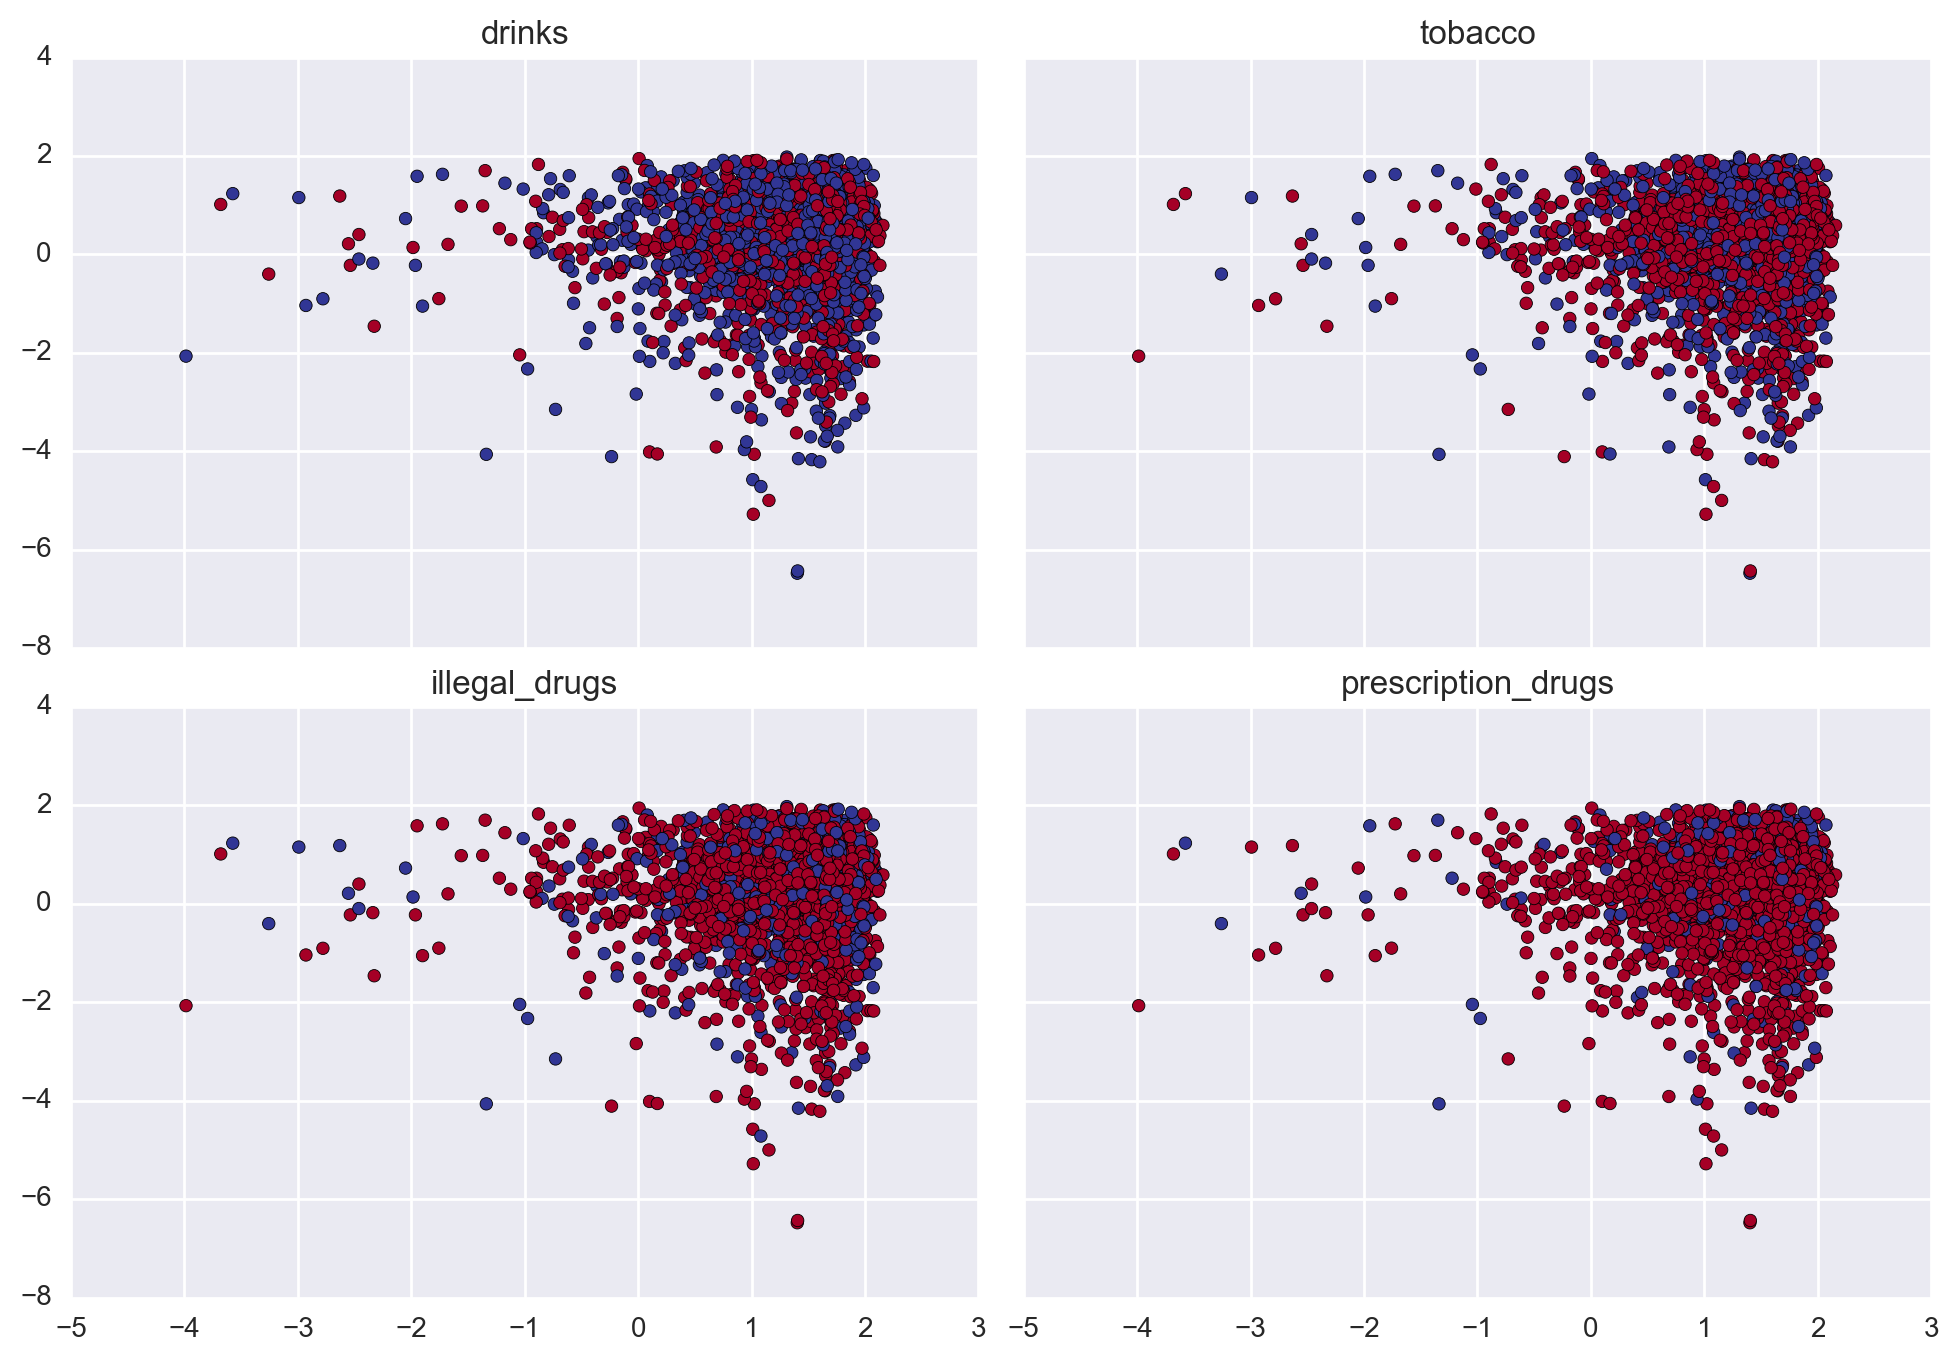

In [167]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (12, 8))
cnt = 0
for i in range(2):
    for j in range(2):
        axes[i, j].scatter(np.log(np.abs(X_red[:, 0])), np.log(np.abs(X_red[:, 1])), c = YResponse[cnt], cmap='RdYlBu');
        axes[i, j].set_title(Y_labels[cnt])
        cnt = cnt + 1
plt.subplots_adjust(wspace = 0.05, hspace = 0.1)

In [168]:
#for component in pca.components_:
#    print(" + ".join("%.3f x %s" % (value, name)
#                     for value, name in zip(component,
#                                            XDesign.columns.tolist())))

---

# <a name="p4">4. Results log</a>

## Run 01

Old SNA analysis and imputation, following list of features considered (i.e. taking out the extra survey questions)

`['age', 'gender', 'race', 'height', 'weight', 'media', 'likes', 'comments', 'follows', 'followed_by', 'mean_likes', 'mean_comments', 'bmi', 'log_follow_ratio', 'log_mean_activity', 'log_magnetism', 'mean_caption_length', 'av_post_weekday', 'av_time_of_day', 'log_rel_deg', 'log_deg_mean', 'log_deg_std', 'largest_clique', 'density', 'edge_count', 'average_clustering', 'clique_count', 'transitivity', 'biconnected', 'node_connectivity', 'edge_connectivity', 'average_connectivity', 'radius', 'diameter', 'average_shortest_path', 'selfies_count', 'node_count', 'selfies_percentage']`

<img src="runs/run01.jpeg">

## Run 02

Old SNA analysis and imputation, following list of features considered (i.e. taking into account the extra survey questions)

`['age', 'gender', 'race', 'height', 'weight', 'media', 'likes', 'comments', 'follows', 'followed_by', 'breakup', 'creativity', 'death_loved', 'food', 'happy', 'major_friendship', 'narcissist', 'other_loss', 'phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'mean_likes', 'mean_comments', 'bmi', 'log_follow_ratio', 'log_mean_activity', 'log_magnetism', 'mean_caption_length', 'av_post_weekday', 'av_time_of_day', 'log_rel_deg', 'log_deg_mean', 'log_deg_std', 'largest_clique', 'density', 'edge_count', 'average_clustering', 'clique_count', 'transitivity', 'biconnected', 'node_connectivity', 'edge_connectivity', 'average_connectivity', 'radius', 'diameter', 'average_shortest_path', 'isolates', 'selfies_count', 'node_count', 'selfies_percentage']`

<img src="runs/run02.jpeg">

## Run 03

SNA analysis with weighted metrics and old imputation, following list of features considered (i.e. taking into account the extra survey questions)

`['age', 'gender', 'race', 'height', 'weight', 'media', 'likes', 'comments', 'follows', 'followed_by', 'breakup', 'creativity', 'death_loved', 'food', 'happy', 'major_friendship', 'narcissist', 'other_loss', 'phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'mean_likes', 'mean_comments', 'bmi', 'log_follow_ratio', 'log_mean_activity', 'log_magnetism', 'mean_caption_length', 'av_post_weekday', 'av_time_of_day', 'log_rel_deg', 'log_deg_mean', 'log_deg_std', 'largest_clique', 'density', 'edge_count', 'average_clustering', 'clique_count', 'transitivity', 'biconnected', 'node_connectivity', 'edge_connectivity', 'average_connectivity', 'radius', 'diameter', 'average_shortest_path', 'isolates', 'selfies_count', 'node_count', 'selfies_percentage']`

<img src="runs/run03.jpeg">

## Run 04

SNA analysis with non-weighted metrics (including the 5 new ones!) and old imputation, following list of features considered (i.e. taking into account the extra survey questions)

`['age', 'gender', 'race', 'height', 'weight', 'media', 'likes', 'comments', 'follows', 'followed_by', 'breakup', 'creativity', 'death_loved', 'food', 'happy', 'major_friendship', 'narcissist', 'other_loss', 'phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'mean_likes', 'mean_comments', 'bmi', 'log_follow_ratio', 'log_mean_activity', 'log_magnetism', 'mean_caption_length', 'av_post_weekday', 'av_time_of_day', 'log_rel_deg', 'log_deg_mean', 'log_deg_std', 'largest_clique', 'density', 'edge_count', 'average_clustering', 'clique_count', 'transitivity', 'biconnected', 'node_connectivity', 'edge_connectivity', 'average_connectivity', 'radius', 'diameter', 'average_shortest_path', 'selfies_count', 'node_count', 'ego_clustering', 'ego_betweenness_centrality', 'selfies_percentage']`

<img src="runs/run04.jpeg">

## Run 05

SNA analysis with weighted metrics (including the 5 new ones!) and old imputation, following list of features considered (i.e. taking into account the extra survey questions)

`['age', 'gender', 'race', 'height', 'weight', 'media', 'likes', 'comments', 'follows', 'followed_by', 'breakup', 'creativity', 'death_loved', 'food', 'happy', 'major_friendship', 'narcissist', 'other_loss', 'phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'mean_likes', 'mean_comments', 'bmi', 'log_follow_ratio', 'log_mean_activity', 'log_magnetism', 'mean_caption_length', 'av_post_weekday', 'av_time_of_day', 'log_rel_deg', 'log_deg_mean', 'log_deg_std', 'largest_clique', 'density', 'edge_count', 'average_clustering', 'clique_count', 'transitivity', 'biconnected', 'node_connectivity', 'edge_connectivity', 'average_connectivity', 'radius', 'diameter', 'average_shortest_path', 'selfies_count', 'node_count', 'ego_clustering', 'ego_betweenness_centrality', 'selfies_percentage']`

<img src="runs/run05.jpeg">

## Run 06

SNA analysis with non-weighted metrics (including the 5 new ones and the metrics from the 12 last 12 months) and old imputation, following list of features considered (i.e. taking into account the extra survey questions)

`['age', 'gender', 'race', 'height', 'weight', 'media', 'likes', 'comments', 'follows', 'followed_by', 'breakup', 'creativity', 'death_loved', 'food', 'happy', 'major_friendship', 'narcissist', 'other_loss', 'phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'mean_likes', 'mean_comments', 'bmi', 'log_follow_ratio', 'log_mean_activity', 'log_magnetism', 'mean_caption_length', 'av_post_weekday', 'av_time_of_day', 'log_rel_deg', 'log_deg_mean', 'log_deg_std', 'largest_clique', 'density', 'edge_count', 'average_clustering', 'clique_count', 'transitivity', 'biconnected', 'node_connectivity', 'edge_connectivity', 'average_connectivity', 'radius', 'diameter', 'average_shortest_path', 'selfies_count', 'node_count', 'ego_clustering', 'ego_betweenness_centrality', 'largest_clique_12', 'density_12', 'edge_count_12', 'average_clustering_12', 'assortativity_12', 'clique_count_12', 'transitivity_12', 'biconnected_12', 'node_connectivity_12', 'edge_connectivity_12', 'average_connectivity_12', 'radius_12', 'diameter_12', 'average_shortest_path_12', 'selfies_count_12', 'node_count_12', 'ego_clustering_12', 'ego_betweenness_centrality_12', 'selfies_percentage']`

<img src="runs/run06.jpeg">

## Run 07

SNA analysis with weighted metrics (including the 5 new ones and the metrics from the 12 last 12 months) and old imputation, following list of features considered (i.e. taking into account the extra survey questions)

`['age', 'gender', 'race', 'height', 'weight', 'media', 'likes', 'comments', 'follows', 'followed_by', 'breakup', 'creativity', 'death_loved', 'food', 'happy', 'major_friendship', 'narcissist', 'other_loss', 'phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'mean_likes', 'mean_comments', 'bmi', 'log_follow_ratio', 'log_mean_activity', 'log_magnetism', 'mean_caption_length', 'av_post_weekday', 'av_time_of_day', 'log_rel_deg', 'log_deg_mean', 'log_deg_std', 'largest_clique', 'density', 'edge_count', 'average_clustering', 'clique_count', 'transitivity', 'biconnected', 'node_connectivity', 'edge_connectivity', 'average_connectivity', 'radius', 'diameter', 'average_shortest_path', 'selfies_count', 'node_count', 'ego_clustering', 'ego_betweenness_centrality', 'largest_clique_12', 'density_12', 'edge_count_12', 'average_clustering_12', 'assortativity_12', 'clique_count_12', 'transitivity_12', 'biconnected_12', 'node_connectivity_12', 'edge_connectivity_12', 'average_connectivity_12', 'radius_12', 'diameter_12', 'average_shortest_path_12', 'selfies_count_12', 'node_count_12', 'ego_clustering_12', 'ego_betweenness_centrality_12', 'selfies_percentage']`

<img src="runs/run07.jpeg">

## Run 08

SNA analysis with non-weighted metrics (including the 5 new ones) ONLY from the last 12 months and old imputation, following list of features considered (i.e. taking into account the extra survey questions)

`['age', 'gender', 'race', 'height', 'weight', 'media', 'likes', 'comments', 'follows', 'followed_by', 'breakup', 'creativity', 'death_loved', 'food', 'happy', 'major_friendship', 'narcissist', 'other_loss', 'phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'mean_likes', 'mean_comments', 'bmi', 'log_follow_ratio', 'log_mean_activity', 'log_magnetism', 'mean_caption_length', 'av_post_weekday', 'av_time_of_day', 'log_rel_deg', 'log_deg_mean', 'log_deg_std', 'largest_clique_12', 'density_12', 'edge_count_12', 'average_clustering_12', 'assortativity_12', 'clique_count_12', 'transitivity_12', 'biconnected_12', 'node_connectivity_12', 'edge_connectivity_12', 'average_connectivity_12', 'radius_12', 'diameter_12', 'average_shortest_path_12', 'selfies_count_12', 'node_count_12', 'ego_clustering_12', 'ego_betweenness_centrality_12', 'selfies_percentage']`

<img src="runs/run08.jpeg">

## Run 09

SNA analysis with weighted metrics (including the 5 new ones) ONLY from the last 12 months and old imputation, following list of features considered (i.e. taking into account the extra survey questions)

<img src="runs/run09.jpeg">

## Run 10

No SNA analysis and old imputation, following list of features considered (i.e. taking into account the extra survey questions):

`['age', 'gender', 'race', 'height', 'weight', 'media', 'likes', 'comments', 'follows', 'followed_by', 'breakup', 'creativity', 'death_loved', 'food', 'happy', 'major_friendship', 'narcissist', 'other_loss', 'phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'mean_likes', 'mean_comments', 'bmi', 'log_follow_ratio', 'log_mean_activity', 'log_magnetism', 'mean_caption_length', 'av_post_weekday', 'av_time_of_day', 'log_rel_deg', 'log_deg_mean', 'log_deg_std', 'selfies_percentage']`

<img src="runs/run10.jpeg">

## Run 11

Old SNA analysis (with those five new features) and new imputation for `av_post_weekday`, following list of features considered (i.e. taking into account the extra survey questions):

`['age', 'gender', 'race', 'height', 'weight', 'media', 'likes', 'comments', 'follows', 'followed_by', 'breakup', 'creativity', 'death_loved', 'food', 'happy', 'major_friendship', 'narcissist', 'other_loss', 'phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'mean_likes', 'mean_comments', 'bmi', 'log_follow_ratio', 'log_mean_activity', 'log_magnetism', 'mean_caption_length', 'av_post_weekday', 'av_time_of_day', 'log_rel_deg', 'log_deg_mean', 'log_deg_std', 'largest_clique', 'density', 'edge_count', 'average_clustering', 'clique_count', 'transitivity', 'biconnected', 'node_connectivity', 'edge_connectivity', 'average_connectivity', 'radius', 'diameter', 'average_shortest_path', 'selfies_count', 'node_count', 'ego_clustering', 'ego_betweenness_centrality', 'selfies_percentage']`

<img src="runs/run11.jpeg">

---

# <a name="p5">5. Version log</a>

## Version 8

* Changed plot options from SVG to retina so they stay in the notebooks
* Implemented an explicit check of F1 score calculation in cross-validation and it reproduces the results of the canned commands
* Including the new PHQ questions in analysis
* Corrected for the weekday bug (thanks Tim)
* Bug with the SNA correlations: before I was only checking for corr = +1, not -1 as well, so now more trivial columns are removed
* Introduced results log
* Introduced simple timers
* Introduced an option for a weighted graph & changed the name of the CSV file that stores the SNA metrics, depending on whether the weighted or a non-weighted graph is chosen
* Added five new SNA metrics
* Added SNA calculation for the previous 12 months since the survey completion, in addition to the full SNA metrics

## Version 7

* Added section on implementing my social shift model (very simple implementation for now)
* Identifying linearly correlated features in the final dataset
* Identifying skewed features and applying Box-Cox to them
* Added option to not consider the early users (that filled out the old version of the survey)
* Exploring SVM with different `C`, `gamma` and `kernel` and RF with CV (that takes a bit)

## Version 6

* Fixed bug in the loop that generates SNA metrics for people that have only selfies
* Fixed the bug in which all the SNA metrics were converted to `int`
* SNA metrics are now saved into a CSV file, so each time one runs the SNA metric generating loop, only the new metrics are calculated (and those are then saved in the CSV file)
* More careful imputation of the SNA metrics for those without any tag network
* Added features: selfie count, selfies percentage, node count, mean caption length, average type of day posting (weekday or weekend), typical time of the day posting (evening, night, morning, afternoon) -- note the potentially problematic imputation of the missing data
* Standardization of continuous variables and dummification to the categorical ones
* Added contents and version log
* Added new survey responses with a choice of a simple imputation for the early users or ignoring them
* Added a bit of PCA
* Playing with parameters of RF and SVM
* Introduced F1 scoring